# Beijing Air Quality Forecasting Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv(r'../datasets/train.csv')
test = pd.read_csv(r'../datasets/test.csv')

In [59]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
display(train.head())
print("\nExplanation: The first few rows help us understand the structure, column types, and spot any obvious data issues. This is the first step in any data science workflow.")

Training Data Overview:


No      DEWP      TEMP      PRES       Iws        Is        Ir  \
0   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353 -0.137667   
1   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353 -0.137667   
2   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353 -0.137667   
3   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353 -0.137667   
4   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353 -0.137667   

              datetime   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
0  2010-01-01 00:00:00  1.448138 -0.732019 -0.522096    NaN  
1  2010-01-01 01:00:00  1.448138 -0.732019 -0.522096    NaN  
2  2010-01-01 02:00:00  1.448138 -0.732019 -0.522096    NaN  
3  2010-01-01 03:00:00  1.448138 -0.732019 -0.522096    NaN  
4  2010-01-01 04:00:00  1.448138 -0.732019 -0.522096    NaN

In [60]:
# List all columns in the training data to check for available features.
print("Columns in training data:")
print(train.columns.tolist())
print("\nExplanation: Listing all columns helps us identify which features are available for modeling and which may need special handling (e.g., categorical, datetime, or target columns).")

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Check the shape of the train and test datasets.
print(f"Train shape: {train.shape}, Test shape: {test.shape}")

(13148, 11)

In [ ]:
# Ensure 'datetime' column is in datetime format for time series analysis.
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)



In [63]:
# Comprehensive summary statistics for numerical columns
numerical_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
summary_stats = train[numerical_cols].describe()
display(summary_stats)
print("\nExplanation: Summary statistics (mean, std, min, max, quartiles) help us understand the distribution, scale, and potential outliers in each feature. This informs scaling choices and highlights data quality issues.")

               DEWP          TEMP          PRES           Iws            Is  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean      -0.029431     -0.062712      0.013612      0.030542      0.016992   
std        0.994087      1.015193      1.008991      1.018337      1.087278   
min       -2.135153     -2.578070     -2.380821     -0.468688     -0.069353   
25%       -0.888034     -0.938521     -0.822670     -0.441894     -0.069353   
50%       -0.056622      0.045209     -0.043595     -0.352512     -0.069353   
75%        0.913358      0.864984      0.832865      0.005216     -0.069353   
max        1.814055      2.340578      2.877939     11.231956     35.439859   

                 Ir         pm2.5  
count  30676.000000  28755.000000  
mean       0.011253    100.793427  
std        1.063811     93.144433  
min       -0.137667      0.000000  
25%       -0.137667     29.000000  
50%       -0.137667     75.000000  
75%       -0.137667    142.000000  


## Visualisations

Text(0, 0.5, 'pm2.5')

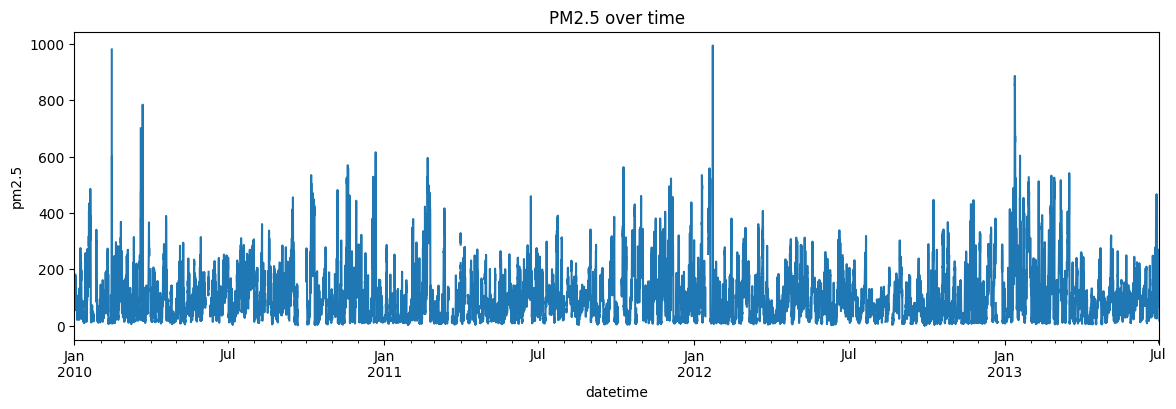

In [ ]:
# Visualize PM2.5 over time to detect trends and seasonality
plt.figure(figsize=(14,4))
train['pm2.5'].plot(title='PM2.5 over time')
plt.ylabel('pm2.5')
plt.show()


In [ ]:
# Reset index to access datetime as a column for feature engineering
train.reset_index(inplace=True)
test.reset_index(inplace=True)

# Extract temporal features for analysis
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['day_of_week'] = train['datetime'].dt.dayofweek
train['day_of_year'] = train['datetime'].dt.dayofyear

print("\nExplanation: Extracting temporal features (year, month, day, hour, day_of_week, day_of_year) allows the model to capture seasonality, daily/weekly cycles, and other time-based patterns that are crucial for accurate forecasting.")

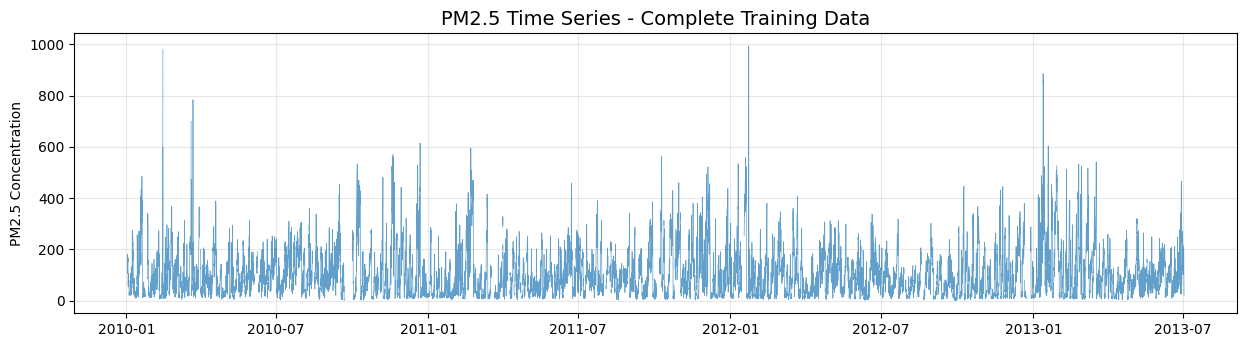

In [66]:
# Plot the full time series to visualize long-term patterns and anomalies
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(train['datetime'], train['pm2.5'], alpha=0.7, linewidth=0.5)
plt.title('PM2.5 Time Series - Complete Training Data', fontsize=14)
plt.ylabel('PM2.5 Concentration')
plt.grid(True, alpha=0.3)
plt.show()
print("\nExplanation: This plot helps us see the overall structure of the data, including long-term trends, periodic spikes, and potential outliers. Such insights are vital for designing robust models and preprocessing steps.")

Text(0.5, 1.0, 'log1p(pm2.5)')

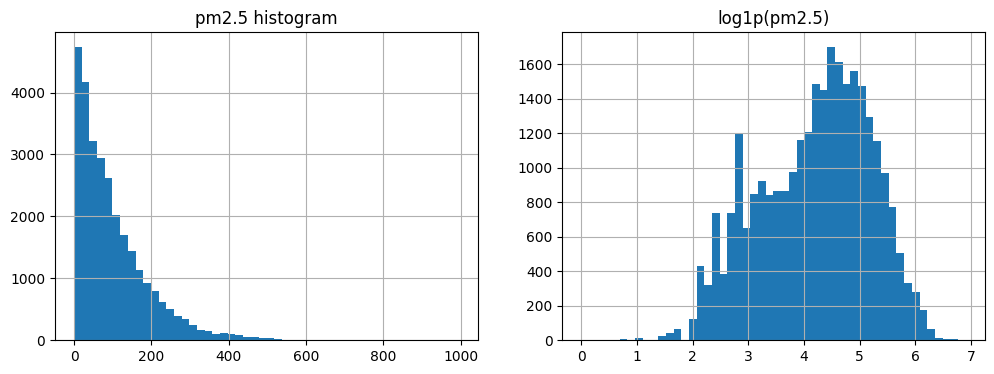

In [ ]:
# Visualizing the distribution of PM2.5 and its log-transform to check for skewness and outliers
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); train['pm2.5'].hist(bins=50); plt.title('pm2.5 histogram')
plt.subplot(1,2,2); np.log1p(train['pm2.5']).hist(bins=50); plt.title('log1p(pm2.5)')
plt.show()


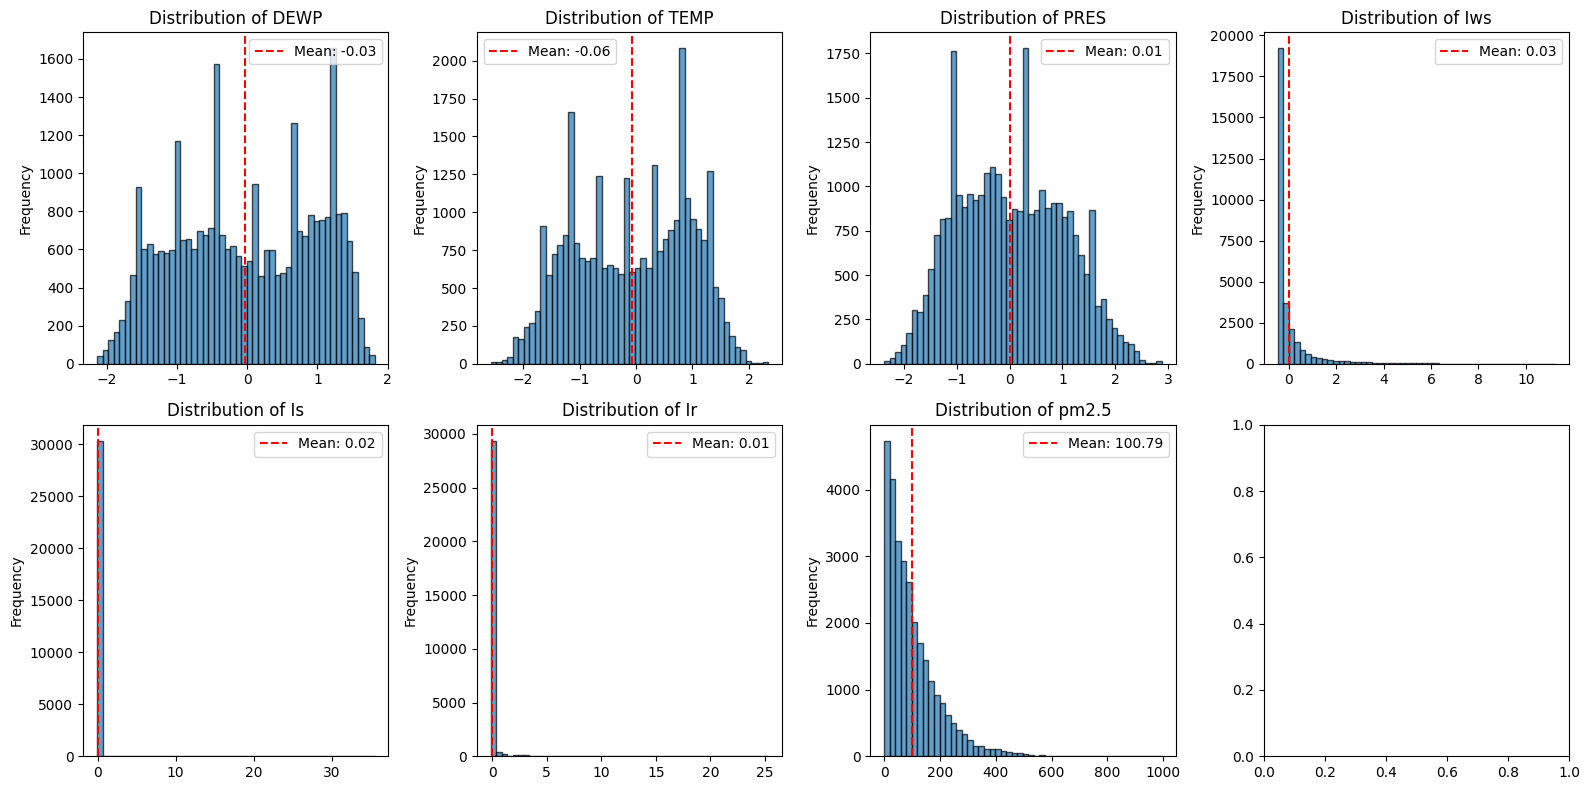

In [68]:
# Distribution analysis for all numerical features
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
numerical_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']

for idx, col in enumerate(numerical_cols):
    row, col_idx = divmod(idx, 4)
    axes[row, col_idx].hist(train[col].dropna(), bins=50, alpha=0.7, edgecolor='black')
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_ylabel('Frequency')
    # Add statistics to plot
    mean_val = train[col].mean()
    std_val = train[col].std()
    axes[row, col_idx].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[row, col_idx].legend()

plt.tight_layout()
plt.show()
print("\nExplanation: Examining the distribution of each feature helps identify outliers, skewness, and the need for scaling or transformation. This step is essential for robust preprocessing and model performance.")

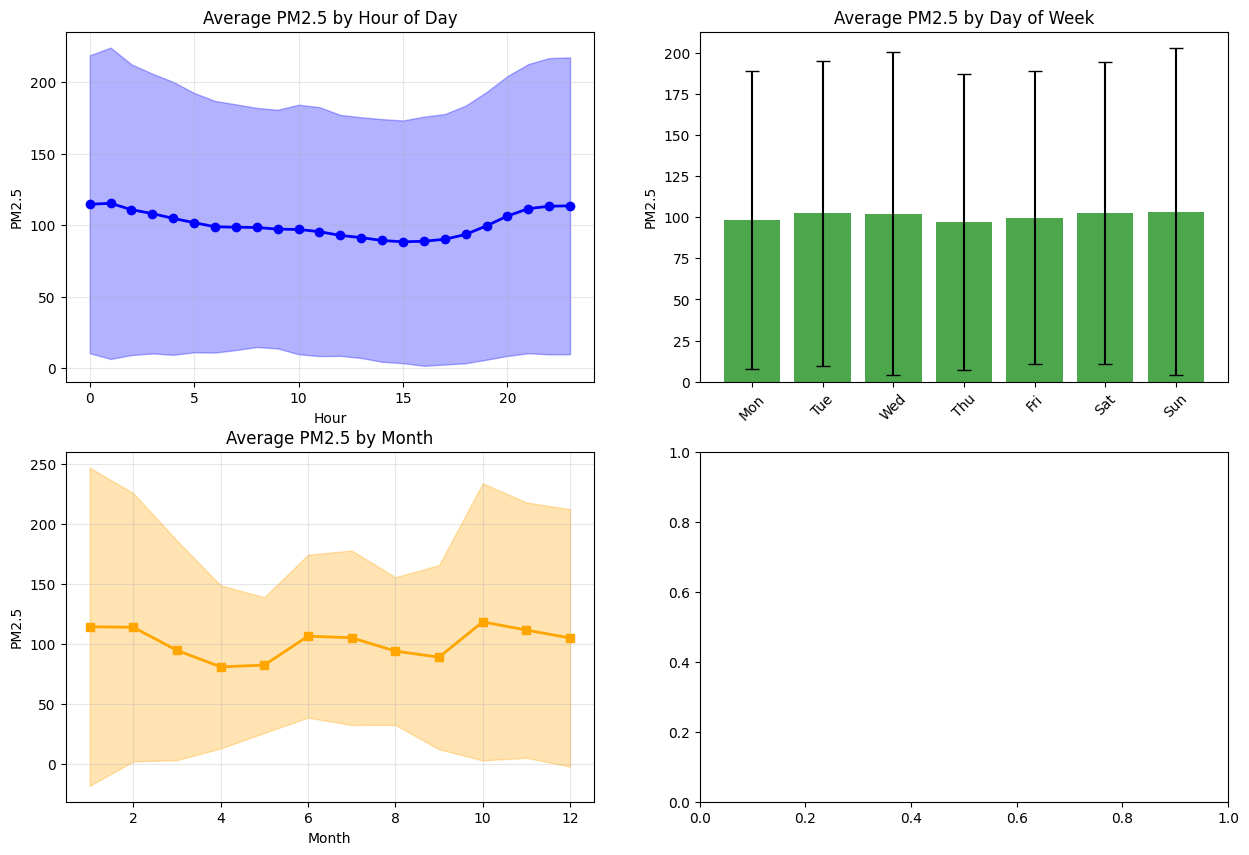

In [69]:
# Explore temporal patterns: hourly, daily, and monthly trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Hourly patterns
hourly_avg = train.groupby('hour')['pm2.5'].agg(['mean', 'std'])
axes[0, 0].plot(hourly_avg.index, hourly_avg['mean'], marker='o', linewidth=2, color='blue')
axes[0, 0].fill_between(hourly_avg.index,
                        hourly_avg['mean'] - hourly_avg['std'],
                        hourly_avg['mean'] + hourly_avg['std'],
                        alpha=0.3, color='blue')
axes[0, 0].set_title('Average PM2.5 by Hour of Day')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('PM2.5')
axes[0, 0].grid(True, alpha=0.3)
# Daily patterns
weekly_avg = train.groupby('day_of_week')['pm2.5'].agg(['mean', 'std'])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(days, weekly_avg['mean'], yerr=weekly_avg['std'],
                alpha=0.7, capsize=5, color='green')
axes[0, 1].set_title('Average PM2.5 by Day of Week')
axes[0, 1].set_ylabel('PM2.5')
axes[0, 1].tick_params(axis='x', rotation=45)
# Monthly patterns
monthly_avg = train.groupby('month')['pm2.5'].agg(['mean', 'std'])
axes[1, 0].plot(monthly_avg.index, monthly_avg['mean'], marker='s', linewidth=2, color='orange')
axes[1, 0].fill_between(monthly_avg.index,
                        monthly_avg['mean'] - monthly_avg['std'],
                        monthly_avg['mean'] + monthly_avg['std'],
                        alpha=0.3, color='orange')
axes[1, 0].set_title('Average PM2.5 by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('PM2.5')
axes[1, 0].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\nExplanation: Temporal pattern plots reveal when pollution peaks (hour, day, month). This informs feature engineering and helps the model learn time-based dependencies, improving forecasting accuracy.")

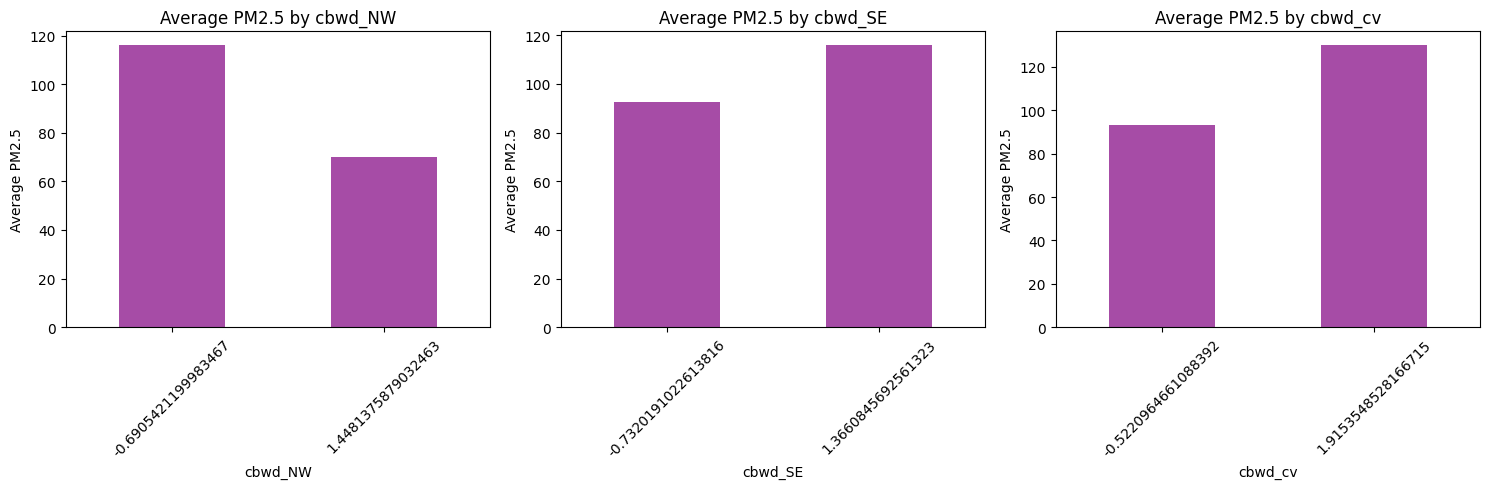

In [70]:
# Analyze wind direction's effect on PM2.5
wind_cols = [col for col in train.columns if 'cbwd' in col]
if wind_cols:
    fig, axes = plt.subplots(1, len(wind_cols), figsize=(15, 5))
    if len(wind_cols) == 1:
        axes = [axes]
    for idx, wind_col in enumerate(wind_cols):
        wind_analysis = train.groupby(wind_col)['pm2.5'].agg(['mean', 'count'])
        wind_analysis['mean'].plot(kind='bar', ax=axes[idx], alpha=0.7, color='purple')
        axes[idx].set_title(f'Average PM2.5 by {wind_col}')
        axes[idx].set_ylabel('Average PM2.5')
        axes[idx].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
print("\nExplanation: Wind direction can influence pollution dispersion. Analyzing its effect helps us decide whether to include it as a feature and how to encode it for the model.")

<Axes: >

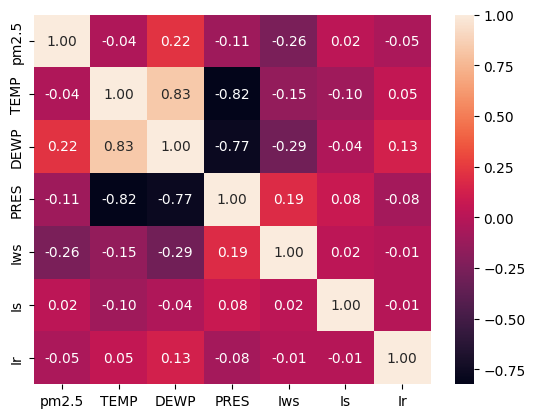

In [71]:
# Correlation heatmap to identify relationships between features and target
cols = ['pm2.5','TEMP','DEWP','PRES','Iws','Is','Ir']
sns.heatmap(train[cols].corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
print("\nExplanation: Correlation analysis helps us identify which features are most related to the target and to each other. Highly correlated features may be redundant, while strong correlations with the target indicate predictive power.")


###  There is a higher correlation betwwen IWS and Pm2.5 amongst the other colums 

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

## DATA PREPROCESSING


In [3]:
train.isnull().sum()

No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64

In [72]:
def handle_missing_lstm(df):
    """Handle missing values with time-series appropriate methods"""
    df_filled = df.copy()
    numerical_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
    # Add pm2.5 only if it exists (training data)
    if 'pm2.5' in df_filled.columns:
        numerical_cols.append('pm2.5')
    for col in numerical_cols:
        if col in df_filled.columns:
            missing_count = df_filled[col].isnull().sum()
            if missing_count > 0:
                print(f"  - Filling {missing_count} missing values in {col}")
                # Linear interpolation + forward/backward fill
                df_filled[col] = df_filled[col].interpolate(method='linear')
                df_filled[col] = df_filled[col].fillna(method='ffill')
                df_filled[col] = df_filled[col].fillna(method='bfill')
    return df_filled

# Apply preprocessing
train_processed = handle_missing_lstm(train)
test_processed  = handle_missing_lstm(test)
print("\nExplanation: Handling missing values is critical for time series models, as gaps can break sequence continuity. Linear interpolation and forward/backward fill are robust for environmental data, preserving trends and seasonality.")

  - Filling 1921 missing values in pm2.5


 ## Feature Engineering


In [73]:

train_processed.reset_index(inplace=True)
test_processed.reset_index(inplace=True)

print("\n CREATING LSTM-OPTIMIZED FEATURES...")

def create_train_features(df):
    """Create features for TRAINING data (includes PM2.5 lag features)"""
    df_features = df.copy()

    # Temporal features
    df_features['hour'] = df_features['datetime'].dt.hour
    df_features['day_of_week'] = df_features['datetime'].dt.dayofweek
    df_features['month'] = df_features['datetime'].dt.month
    df_features['day_of_year'] = df_features['datetime'].dt.dayofyear

    # Cyclic encoding
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['dow_sin']  = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['dow_cos']  = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features['doy_sin']   = np.sin(2 * np.pi * df_features['day_of_year'] / 365)
    df_features['doy_cos']   = np.cos(2 * np.pi * df_features['day_of_year'] / 365)

    # Weather interactions
    df_features['temp_dewp_diff'] = df_features['TEMP'] - df_features['DEWP']
    df_features['wind_temp_interaction'] = df_features['Iws'] * df_features['TEMP']
    df_features['pressure_temp_ratio'] = df_features['PRES'] / (df_features['TEMP'] + 273.15)

    # Lag + rolling stats (training only, since test has no pm2.5)
    if 'pm2.5' in df_features.columns:
        for lag in [1, 2, 3, 6, 12, 24]:
            df_features[f'pm2.5_lag_{lag}'] = df_features['pm2.5'].shift(lag)
        for window in [3, 6, 12, 24]:
            df_features[f'pm2.5_rolling_mean_{window}'] = df_features['pm2.5'].rolling(window=window).mean()
            df_features[f'pm2.5_rolling_std_{window}']  = df_features['pm2.5'].rolling(window=window).std()

    return df_features

def create_test_features(df):
    """Create features for TEST data (NO PM2.5 lag features)"""
    df_features = df.copy()

    # Temporal features
    df_features['hour'] = df_features['datetime'].dt.hour
    df_features['day_of_week'] = df_features['datetime'].dt.dayofweek
    df_features['month'] = df_features['datetime'].dt.month
    df_features['day_of_year'] = df_features['datetime'].dt.dayofyear

    # Cyclic encoding
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['dow_sin']  = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['dow_cos']  = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features['doy_sin']   = np.sin(2 * np.pi * df_features['day_of_year'] / 365)
    df_features['doy_cos']   = np.cos(2 * np.pi * df_features['day_of_year'] / 365)

    # Weather interactions
    df_features['temp_dewp_diff'] = df_features['TEMP'] - df_features['DEWP']
    df_features['wind_temp_interaction'] = df_features['Iws'] * df_features['TEMP']
    df_features['pressure_temp_ratio'] = df_features['PRES'] / (df_features['TEMP'] + 273.15)

    return df_features

train_featured = create_train_features(train_processed)
test_featured  = create_test_features(test_processed)

print(f"Train features created: {train_featured.shape[1]} columns")
print(f" Test features created: {test_featured.shape[1]} columns")



 CREATING LSTM-OPTIMIZED FEATURES...
Train features created: 44 columns
 Test features created: 27 columns


## Encoding categoral features


In [74]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = [col for col in train_featured.columns if 'cbwd' in col]
label_encoders = {}

for col in categorical_cols:
    if col in test_featured.columns:
        le = LabelEncoder()
        combined_values = pd.concat([train_featured[col], test_featured[col]]).astype(str)
        le.fit(combined_values)

        train_featured[col] = le.transform(train_featured[col].astype(str))
        test_featured[col]  = le.transform(test_featured[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col} with {len(le.classes_)} categories")


Encoded cbwd_NW with 2 categories

Encoded cbwd_SE with 2 categories
Encoded cbwd_cv with 2 categories
Encoded cbwd_SE with 2 categories
Encoded cbwd_cv with 2 categories


In [75]:
# Exclude non-numeric columns
non_numeric_cols = ['level_0', 'index', 'No', 'datetime']  # adjust if needed
common_feature_cols = [col for col in train_featured.columns
                       if col in test_featured.columns and col not in non_numeric_cols + ['pm2.5']]

print(f"Common numeric features: {len(common_feature_cols)} columns")
print(f"Features: {common_feature_cols[:10]}...")


from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit on train, apply to both
feature_scaler.fit(train_featured[common_feature_cols])
target_scaler.fit(train_featured[['pm2.5']])

train_featured_scaled = train_featured.copy()
test_featured_scaled  = test_featured.copy()

# 1. Convert features to float32
train_featured_scaled[common_feature_cols] = train_featured_scaled[common_feature_cols].astype('float32')
test_featured_scaled[common_feature_cols] = test_featured_scaled[common_feature_cols].astype('float32')

# 2. Create the scaled target column and make it float32
train_featured_scaled['pm2.5_scaled'] = target_scaler.transform(train_featured[['pm2.5']]).astype('float32').flatten()



print(f"Scaled {len(common_feature_cols)} common features and target variable")
print(f" Final training data shape: {train_featured_scaled.shape}")
print(f"Final test data shape: {test_featured_scaled.shape}")


Common numeric features: 24 columns
Features: ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'month']...
Scaled 24 common features and target variable
 Final training data shape: (30676, 45)
Final test data shape: (13148, 27)
Scaled 24 common features and target variable
 Final training data shape: (30676, 45)
Final test data shape: (13148, 27)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
def create_lstm_sequences_generator(train_df, test_df, feature_cols, lookback=24, forecast_horizon=1, batch_size=32, val_split=0.2):
    
    import numpy as np
    
    # Clean training data
    train_df_clean = train_df.dropna(subset=feature_cols + ['pm2.5_scaled']).reset_index(drop=True)
    total_train = len(train_df_clean)
    val_size = int(total_train * val_split)
    
    train_indices = (0, total_train - val_size)
    val_indices = (total_train - val_size, total_train)
    
    def generator(df, start_idx, end_idx):
        i = start_idx + lookback
        while True:  # <-- repeat forever
            X_batch, y_batch = [], []
            for _ in range(batch_size):
                if i >= end_idx - forecast_horizon + 1:
                    i = start_idx + lookback  # restart from beginning
                X_seq = df[feature_cols].iloc[i-lookback:i].values.astype('float32')
                if forecast_horizon == 1:
                    y_seq = df['pm2.5_scaled'].iloc[i].astype('float32')
                else:
                    y_seq = df['pm2.5_scaled'].iloc[i:i+forecast_horizon].values.astype('float32')
                X_batch.append(X_seq)
                y_batch.append(y_seq)
                i += 1
            yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')
    
    # Training and validation generators
    train_gen = generator(train_df_clean, *train_indices)
    val_gen = generator(train_df_clean, *val_indices)
    
    steps_per_epoch = max(1, (train_indices[1] - train_indices[0] - lookback) // batch_size)
    val_steps = max(1, (val_indices[1] - val_indices[0] - lookback) // batch_size)

    # Build test sequences (still in memory, smaller)
    test_df_clean = test_df.dropna(subset=feature_cols).reset_index(drop=True)
    X_test = []
    for i in range(lookback, len(test_df_clean)):
        X_seq = test_df_clean[feature_cols].iloc[i-lookback:i].values.astype('float32')
        X_test.append(X_seq)
    X_test = np.array(X_test, dtype='float32')
    
    print(f"Train steps: {steps_per_epoch}, Validation steps: {val_steps}, Test sequences: {X_test.shape}")
    print(f"Each sequence uses {lookback} time steps with {len(feature_cols)} features")
    
    return train_gen, val_gen, X_test, steps_per_epoch, val_steps


### Faced Memory Issuses while trying to run the code, decide to use generators since its memeory effiecient 

# Build Model

I initialized all the experiments and set up the model to continue training . Initially, I was running each experiment separately, which made the notebook difficult to navigate and track. To improve workflow, I consolidated the process into a looped experiment setup, making it easier to manage multiple runs while keeping the notebook cleaner and more organized.


===== Experiment 1: LSTM, 1 layers, 50 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 53s 33ms/step - loss: 0.9363 - mae: 0.7285 - val_loss: 1.3983 - val_mae: 0.8174 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 53s 33ms/step - loss: 0.9363 - mae: 0.7285 - val_loss: 1.3983 - val_mae: 0.8174 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 52s 34ms/step - loss: 0.8812 - mae: 0.7077 - val_loss: 1.2801 - val_mae: 0.7929 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 52s 34ms/step - loss: 0.8812 - mae: 0.7077 - val_loss: 1.2801 - val_mae: 0.7929 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 61s 40ms/step - l

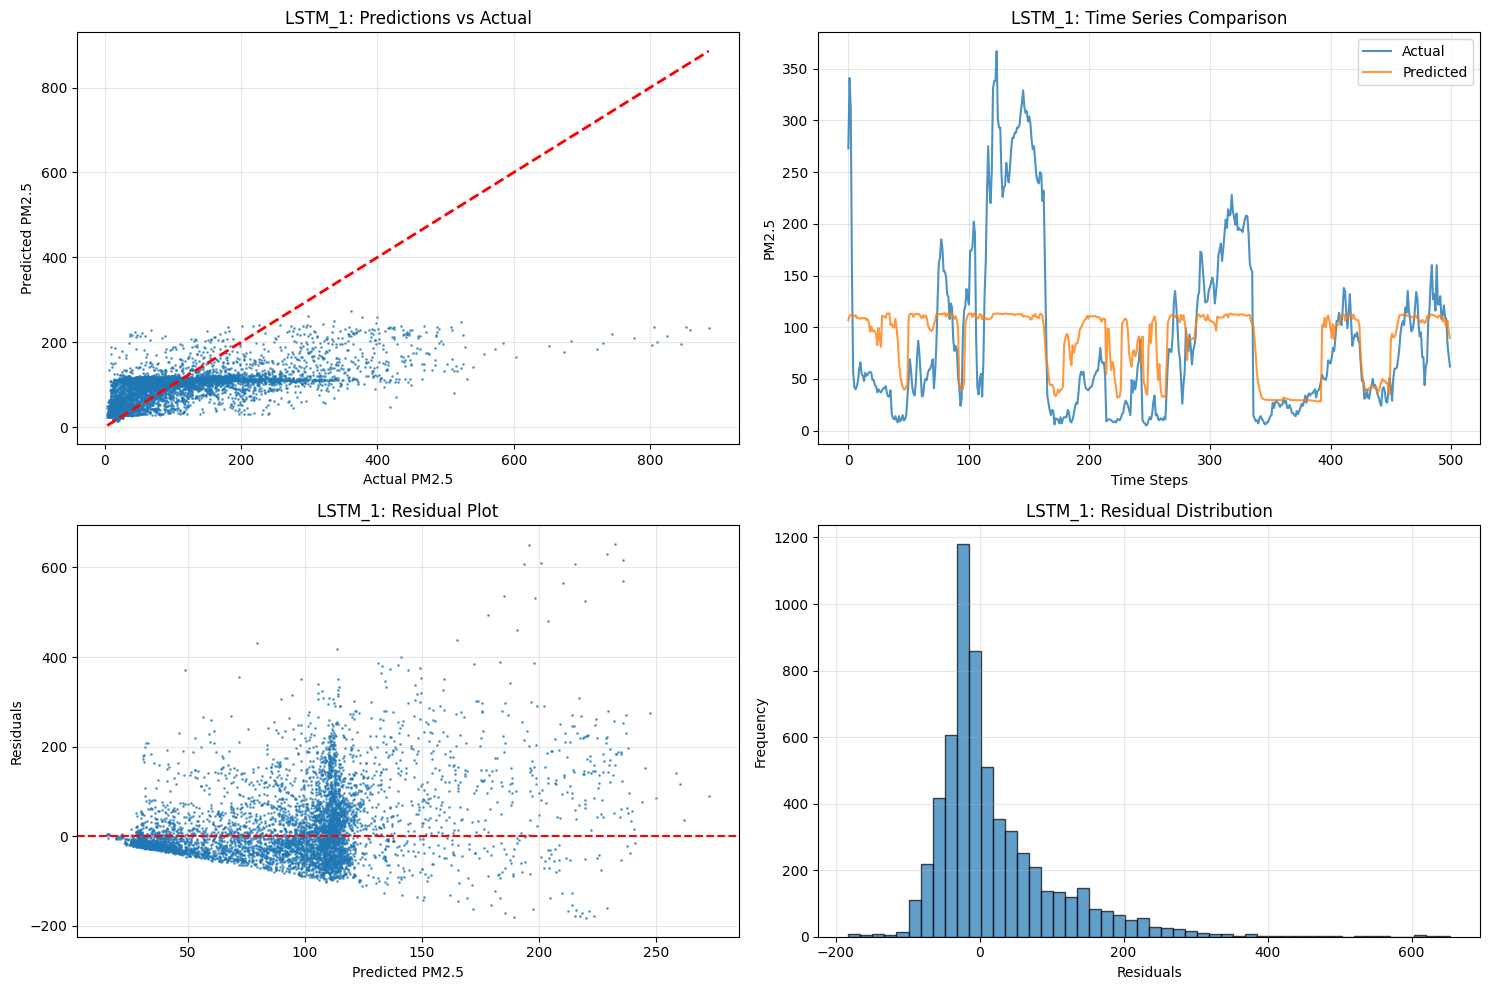


===== Experiment 2: LSTM, 2 layers, 100 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 95s 59ms/step - loss: 0.9388 - mae: 0.7316 - val_loss: 1.4397 - val_mae: 0.8254 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 95s 59ms/step - loss: 0.9388 - mae: 0.7316 - val_loss: 1.4397 - val_mae: 0.8254 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 74s 48ms/step - loss: 0.8795 - mae: 0.6951 - val_loss: 1.4349 - val_mae: 0.8076 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 74s 48ms/step - loss: 0.8795 - mae: 0.6951 - val_loss: 1.4349 - val_mae: 0.8076 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 73s 47ms/step - 

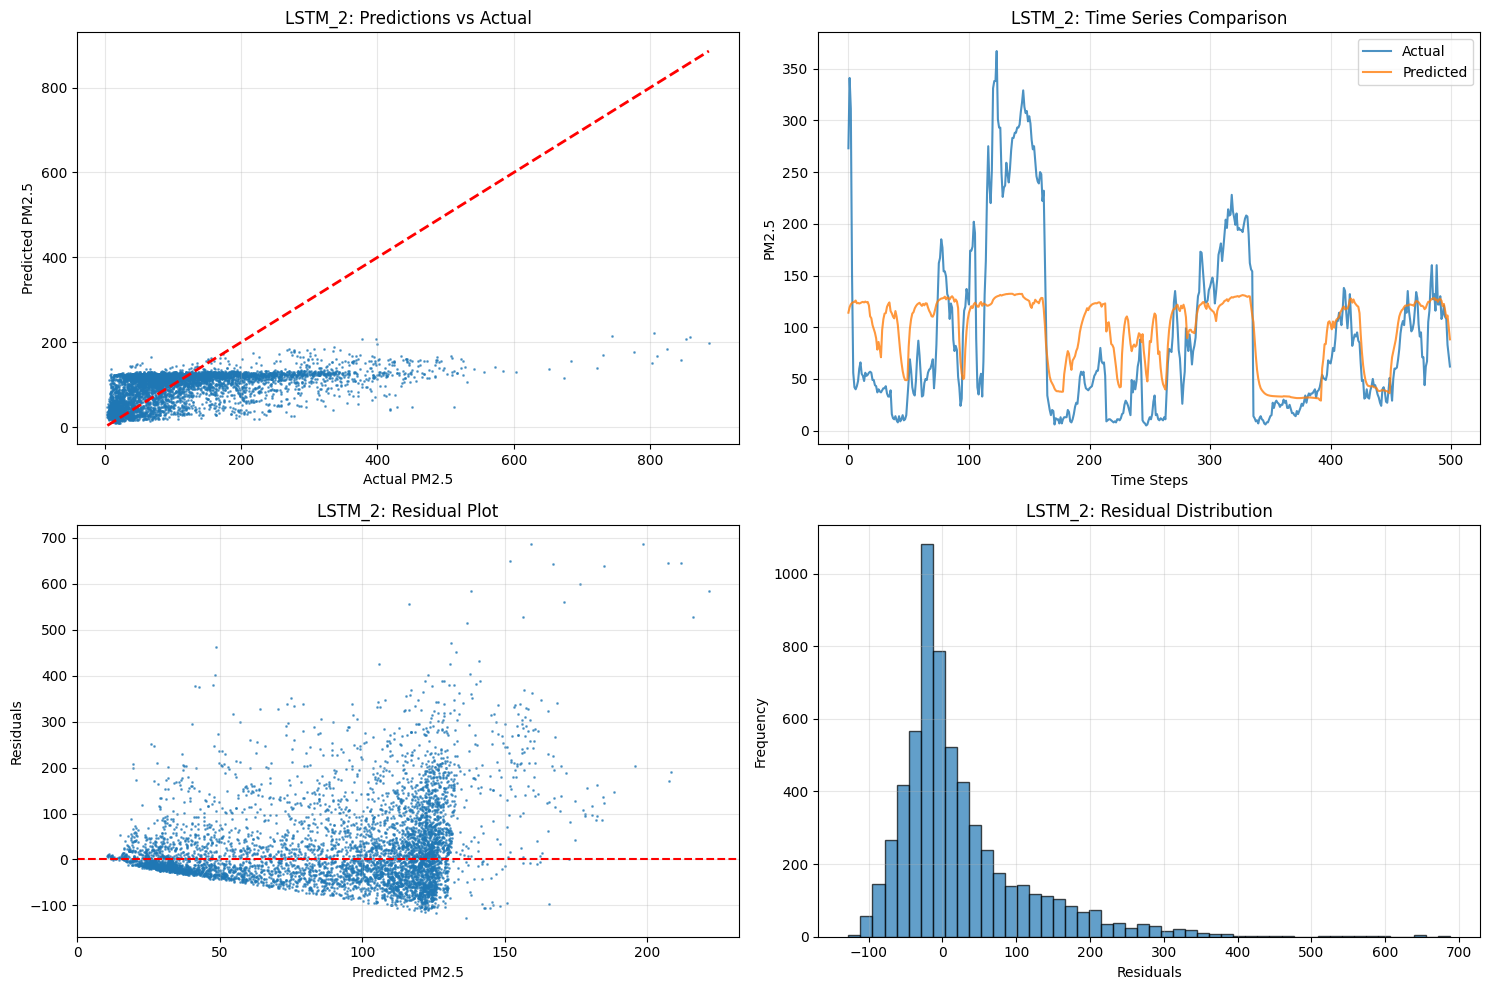


===== Experiment 3: LSTM, 2 layers, 100 units, adam, lr=0.0005, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 54s 34ms/step - loss: 0.9506 - mae: 0.7346 - val_loss: 1.4242 - val_mae: 0.8182 - lr: 5.0000e-04
Epoch 2/5
1532/1532 [==============================] - 54s 34ms/step - loss: 0.9506 - mae: 0.7346 - val_loss: 1.4242 - val_mae: 0.8182 - lr: 5.0000e-04
Epoch 2/5
1532/1532 [==============================] - 49s 32ms/step - loss: 0.8545 - mae: 0.6824 - val_loss: 1.3590 - val_mae: 0.7815 - lr: 5.0000e-04
Epoch 3/5
1532/1532 [==============================] - 49s 32ms/step - loss: 0.8545 - mae: 0.6824 - val_loss: 1.3590 - val_mae: 0.7815 - lr: 5.0000e-04
Epoch 3/5
1532/1532 [==============================] -

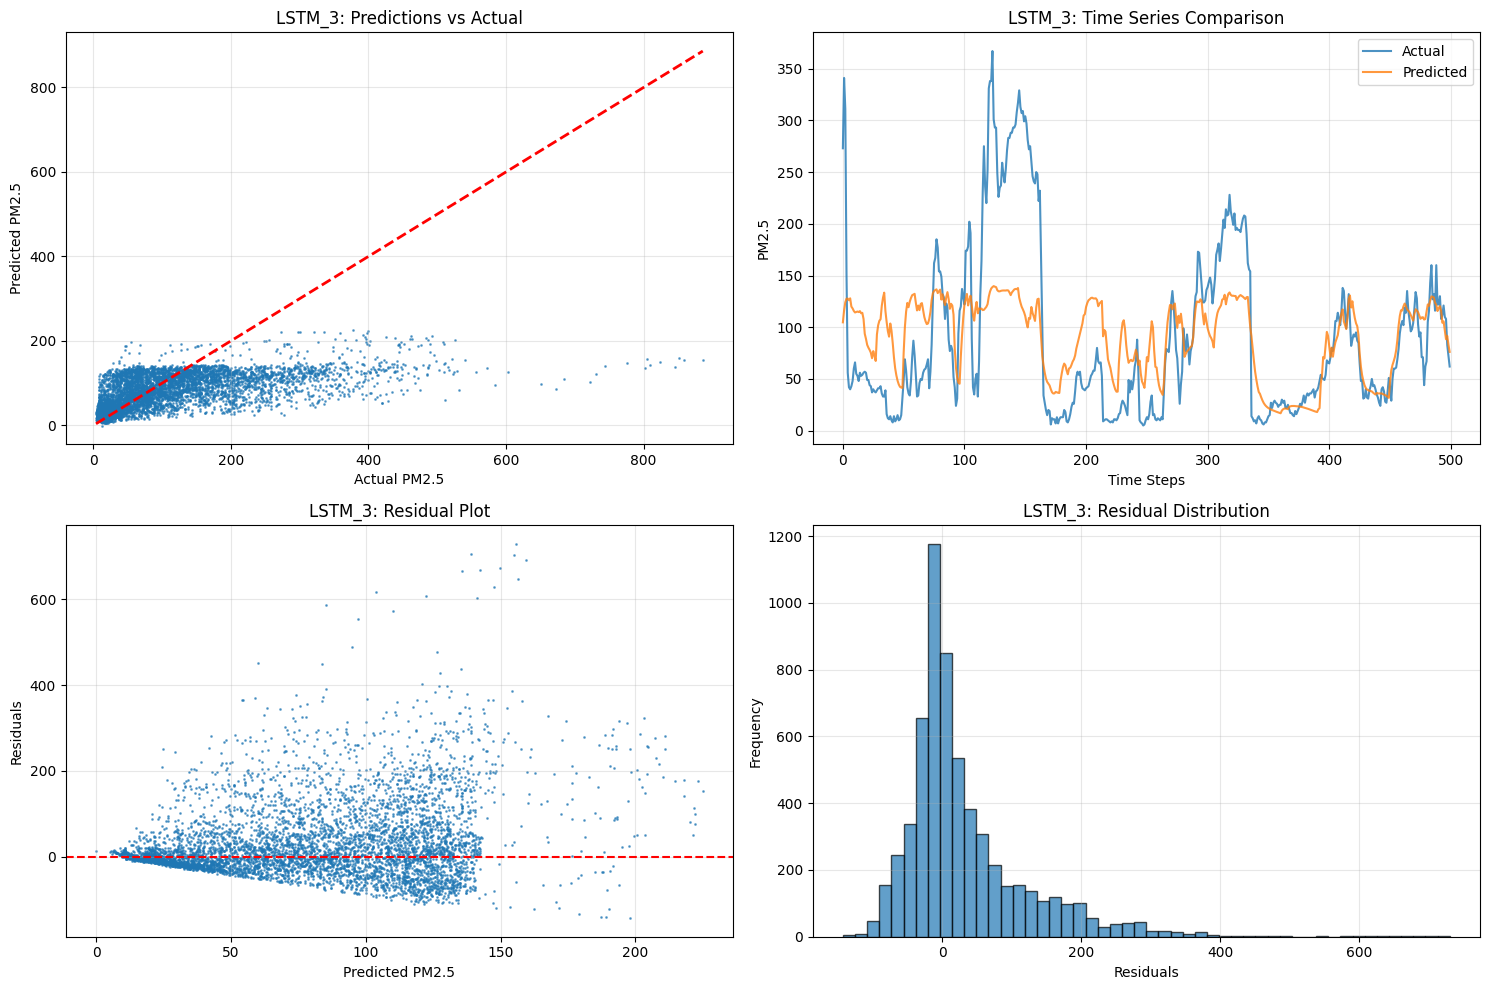


===== Experiment 4: LSTM, 2 layers, 100 units, sgd, lr=0.01, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 120s 77ms/step - loss: 0.8265 - mae: 0.6755 - val_loss: 1.4538 - val_mae: 0.8230 - lr: 0.0100
Epoch 2/5
1532/1532 [==============================] - 120s 77ms/step - loss: 0.8265 - mae: 0.6755 - val_loss: 1.4538 - val_mae: 0.8230 - lr: 0.0100
Epoch 2/5
1532/1532 [==============================] - 82s 54ms/step - loss: 0.8570 - mae: 0.6949 - val_loss: 1.4461 - val_mae: 0.8220 - lr: 0.0100
Epoch 3/5
1532/1532 [==============================] - 82s 54ms/step - loss: 0.8570 - mae: 0.6949 - val_loss: 1.4461 - val_mae: 0.8220 - lr: 0.0100
Epoch 3/5
1532/1532 [==============================] - 114s 74ms/step -

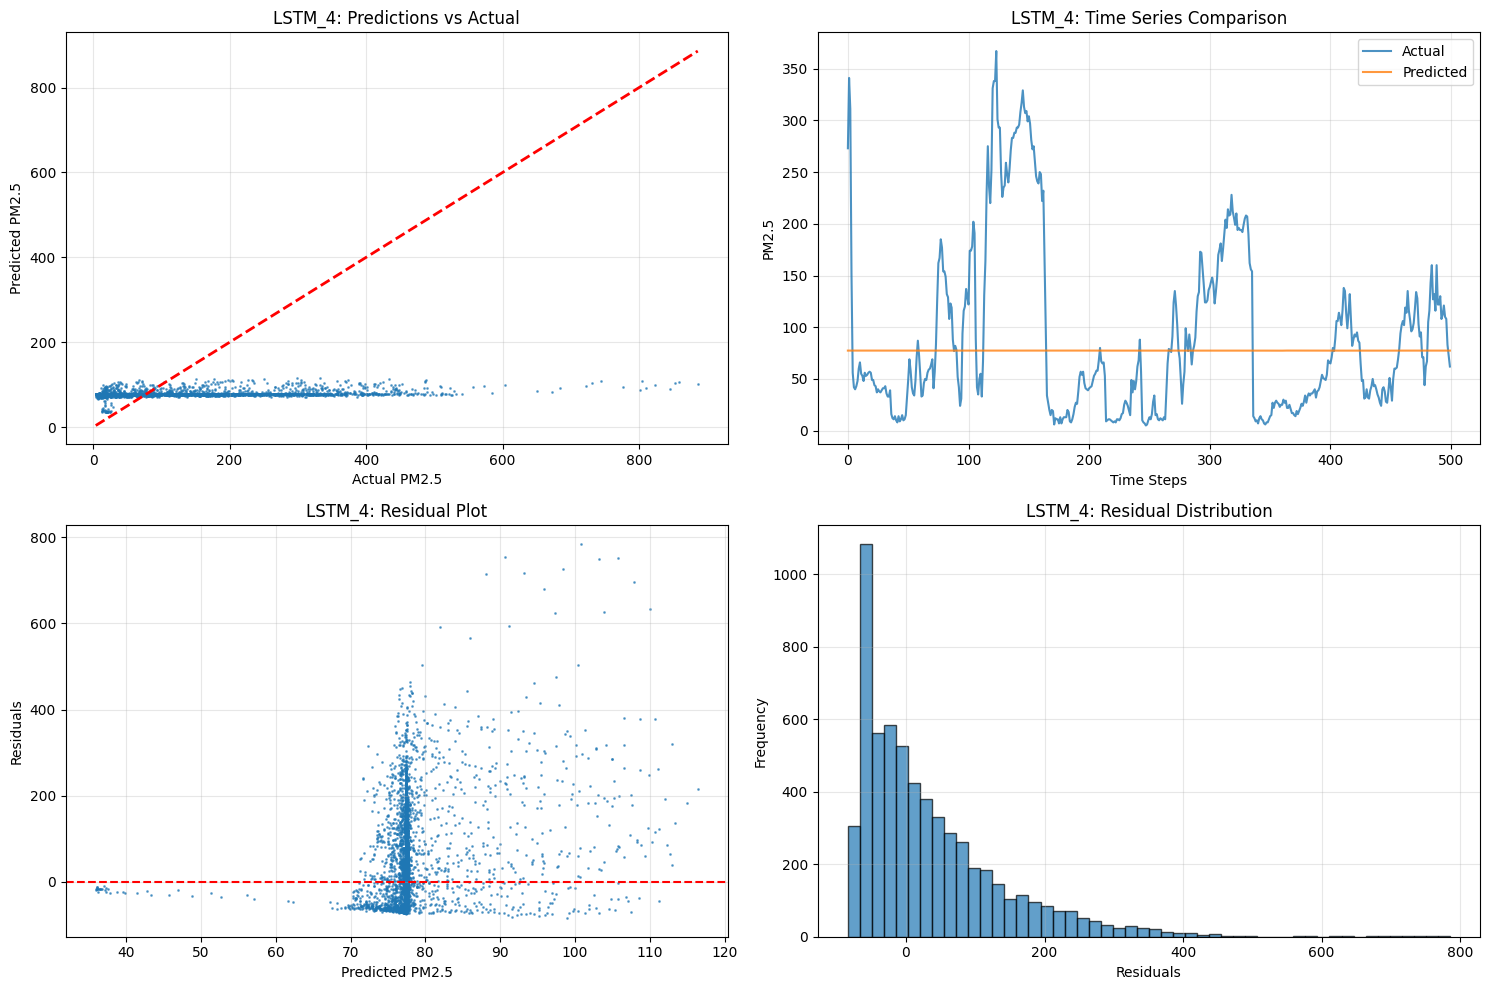


===== Experiment 5: GRU, 1 layers, 50 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 118s 74ms/step - loss: 1.0929 - mae: 0.7883 - val_loss: 1.5291 - val_mae: 0.8434 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 118s 74ms/step - loss: 1.0929 - mae: 0.7883 - val_loss: 1.5291 - val_mae: 0.8434 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 90s 59ms/step - loss: 0.9500 - mae: 0.7355 - val_loss: 1.3496 - val_mae: 0.7803 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 90s 59ms/step - loss: 0.9500 - mae: 0.7355 - val_loss: 1.3496 - val_mae: 0.7803 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 134s 88ms/step -

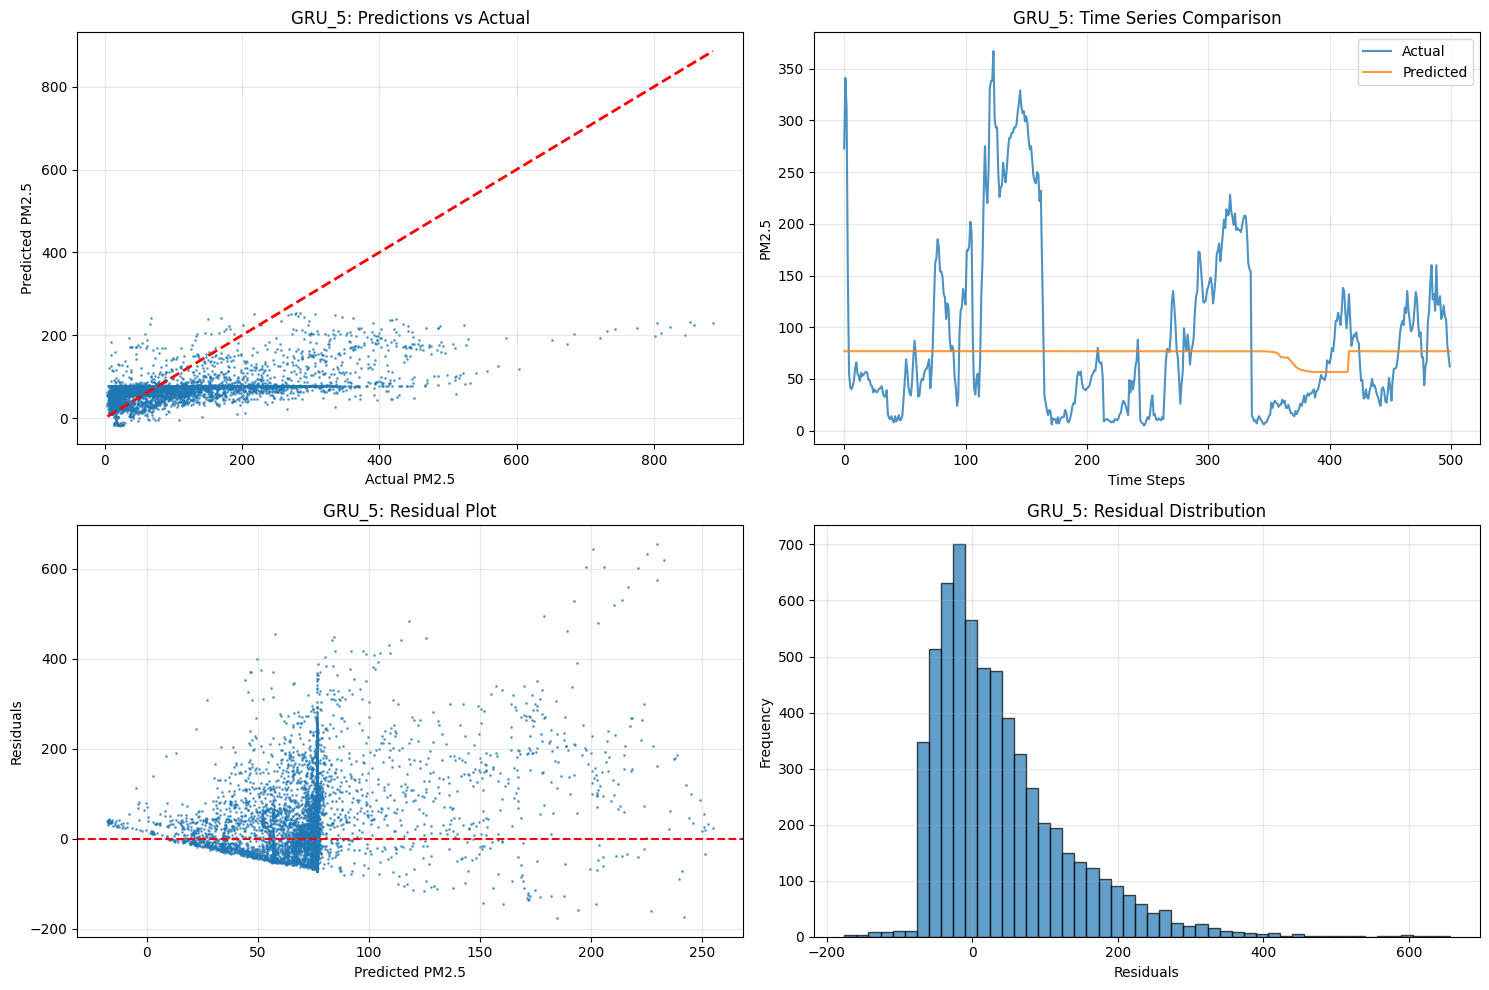


===== Experiment 6: GRU, 2 layers, 100 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 149s 92ms/step - loss: 1.1007 - mae: 0.7842 - val_loss: 1.4000 - val_mae: 0.8137 - lr: 0.0010
Epoch 2/5
Epoch 2/5
1532/1532 [==============================] - 109s 71ms/step - loss: 0.9067 - mae: 0.7052 - val_loss: 1.3190 - val_mae: 0.7853 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 109s 71ms/step - loss: 0.9067 - mae: 0.7052 - val_loss: 1.3190 - val_mae: 0.7853 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 75s 49ms/step - loss: 0.8228 - mae: 0.6584 - val_loss: 1.3046 - val_mae: 0.7839 - lr: 0.0010
Epoch 4/5
1532/1532 [==============================] - 75s 

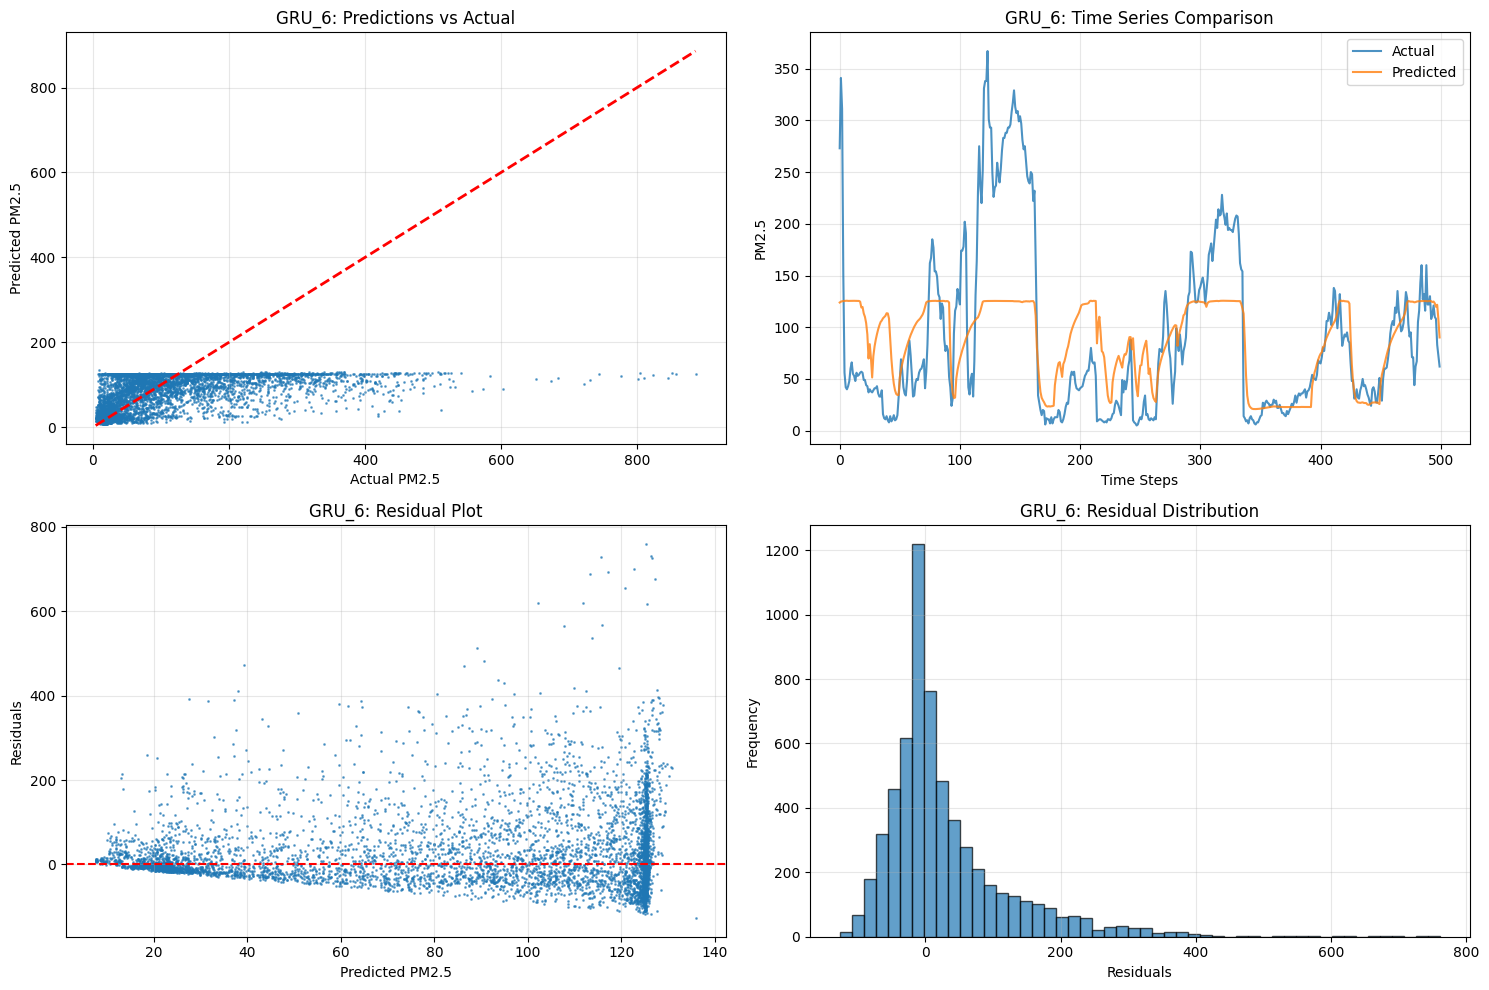


===== Experiment 7: GRU, 2 layers, 100 units, adam, lr=0.0005, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 87s 53ms/step - loss: 1.0882 - mae: 0.7822 - val_loss: 1.3107 - val_mae: 0.8108 - lr: 5.0000e-04
Epoch 2/5
1532/1532 [==============================] - 87s 53ms/step - loss: 1.0882 - mae: 0.7822 - val_loss: 1.3107 - val_mae: 0.8108 - lr: 5.0000e-04
Epoch 2/5
1532/1532 [==============================] - 83s 54ms/step - loss: 0.9181 - mae: 0.7095 - val_loss: 1.1805 - val_mae: 0.7585 - lr: 5.0000e-04
Epoch 3/5
1532/1532 [==============================] - 83s 54ms/step - loss: 0.9181 - mae: 0.7095 - val_loss: 1.1805 - val_mae: 0.7585 - lr: 5.0000e-04
Epoch 3/5
1532/1532 [==============================] - 

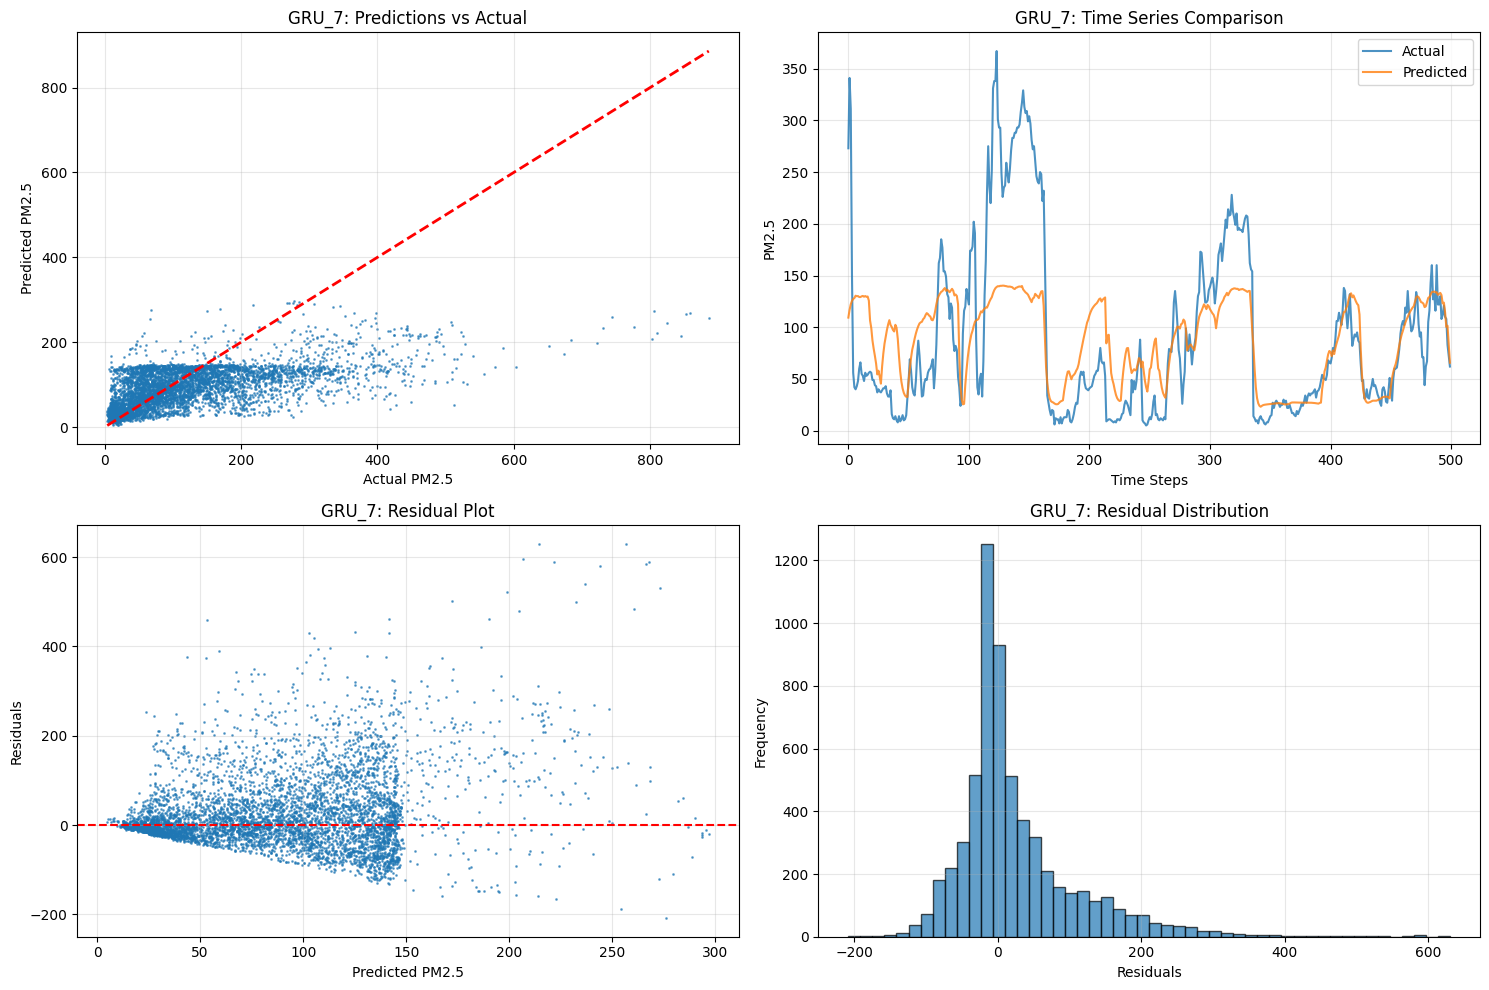


===== Experiment 8: GRU, 2 layers, 100 units, sgd, lr=0.01, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 142s 90ms/step - loss: 0.8022 - mae: 0.6579 - val_loss: 1.4296 - val_mae: 0.8232 - lr: 0.0100
Epoch 2/5
Epoch 2/5
1532/1532 [==============================] - 165s 108ms/step - loss: 0.8255 - mae: 0.6789 - val_loss: 1.4189 - val_mae: 0.8214 - lr: 0.0100
Epoch 3/5
Epoch 3/5
1532/1532 [==============================] - 151s 99ms/step - loss: 0.8244 - mae: 0.6774 - val_loss: 1.4293 - val_mae: 0.8223 - lr: 0.0100
Epoch 4/5
1532/1532 [==============================] - 151s 99ms/step - loss: 0.8244 - mae: 0.6774 - val_loss: 1.4293 - val_mae: 0.8223 - lr: 0.0100
Epoch 4/5
1532/1532 [============================

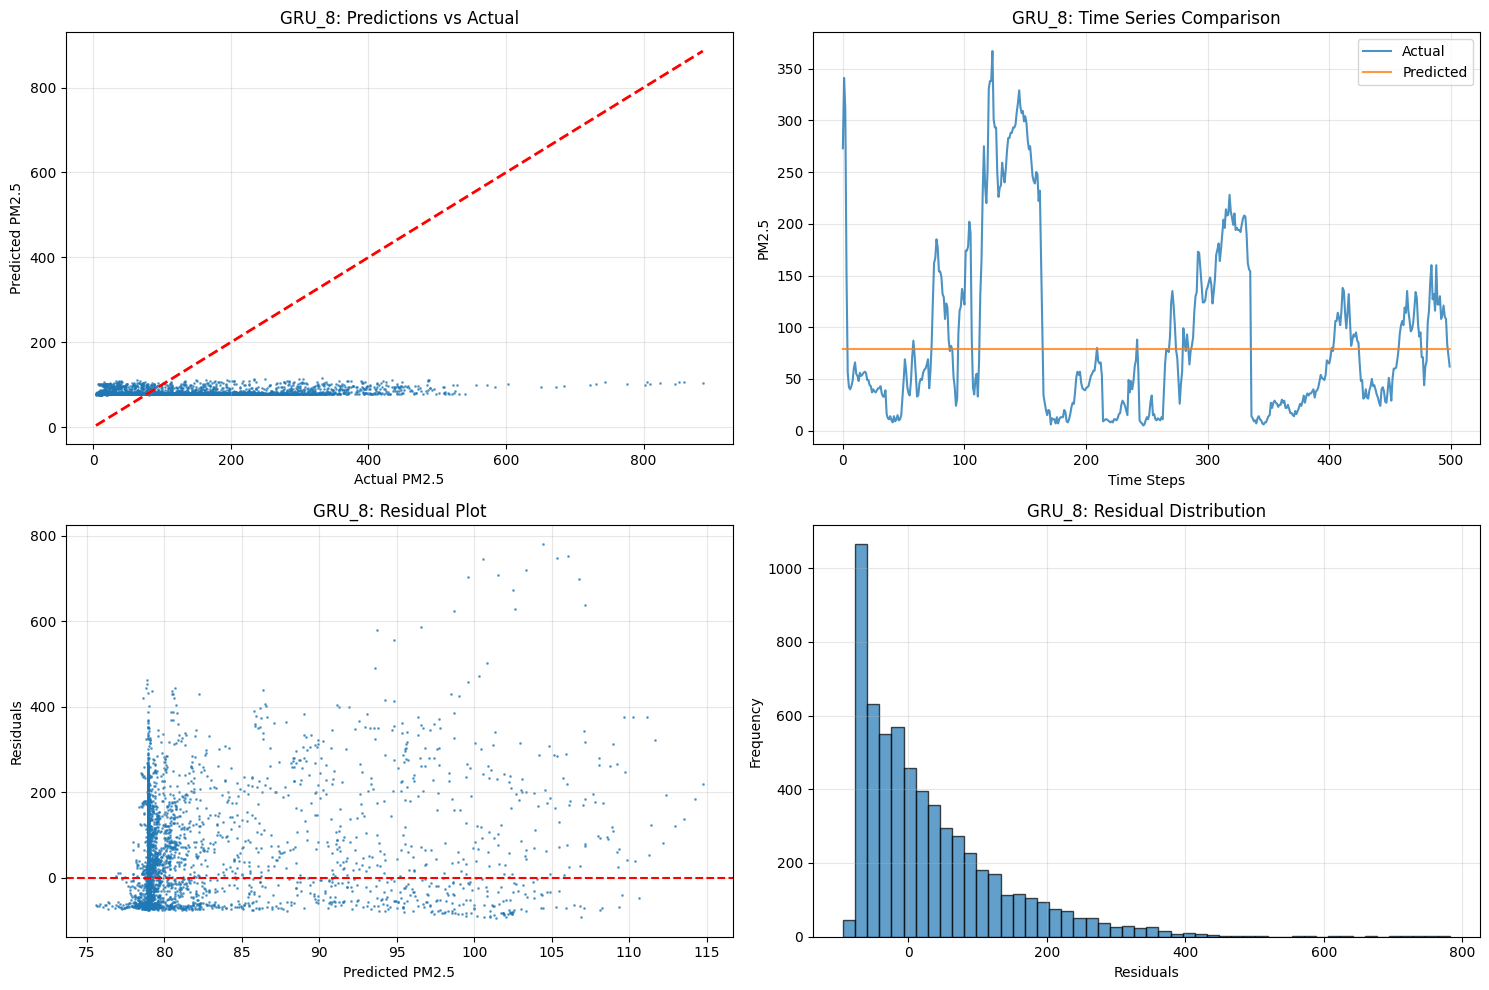


===== Experiment 9: LSTM, 2 layers, 100 units, adam, lr=0.001, batch=32 =====
Train steps: 766, Validation steps: 190, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 766, Validation steps: 190, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
766/766 [==============================] - 49s 61ms/step - loss: 0.9519 - mae: 0.7360 - val_loss: 1.4430 - val_mae: 0.8273 - lr: 0.0010
Epoch 2/5
766/766 [==============================] - 49s 61ms/step - loss: 0.9519 - mae: 0.7360 - val_loss: 1.4430 - val_mae: 0.8273 - lr: 0.0010
Epoch 2/5
766/766 [==============================] - 44s 57ms/step - loss: 0.9041 - mae: 0.7151 - val_loss: 1.4363 - val_mae: 0.8139 - lr: 0.0010
Epoch 3/5
766/766 [==============================] - 44s 57ms/step - loss: 0.9041 - mae: 0.7151 - val_loss: 1.4363 - val_mae: 0.8139 - lr: 0.0010
Epoch 3/5
766/766 [==============================] - 43s 56ms/step - loss: 0.8355

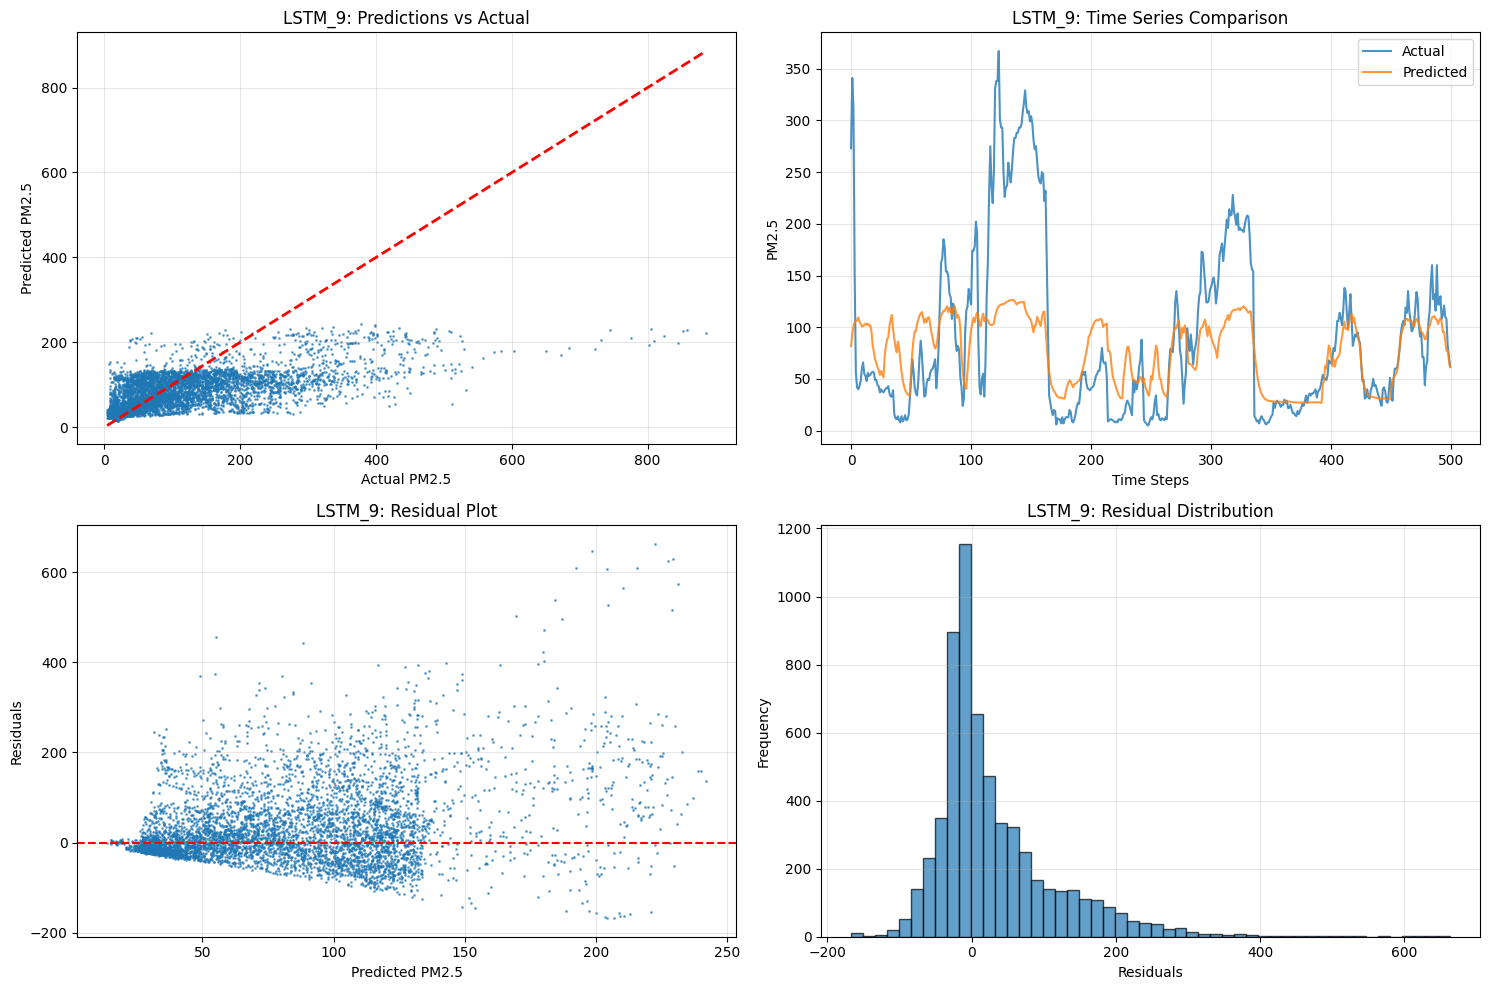


===== Experiment 10: LSTM, 2 layers, 100 units, adam, lr=0.001, batch=8 =====
Train steps: 3064, Validation steps: 763, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 3064, Validation steps: 763, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
3064/3064 [==============================] - 63s 20ms/step - loss: 0.9393 - mae: 0.7283 - val_loss: 1.4556 - val_mae: 0.8255 - lr: 0.0010
Epoch 2/5
3064/3064 [==============================] - 63s 20ms/step - loss: 0.9393 - mae: 0.7283 - val_loss: 1.4556 - val_mae: 0.8255 - lr: 0.0010
Epoch 2/5
3064/3064 [==============================] - 57s 19ms/step - loss: 0.8823 - mae: 0.6972 - val_loss: 1.4584 - val_mae: 0.8210 - lr: 0.0010
Epoch 3/5
3064/3064 [==============================] - 57s 19ms/step - loss: 0.8823 - mae: 0.6972 - val_loss: 1.4584 - val_mae: 0.8210 - lr: 0.0010
Epoch 3/5
3064/3064 [==============================] - 57s 19ms/step - 

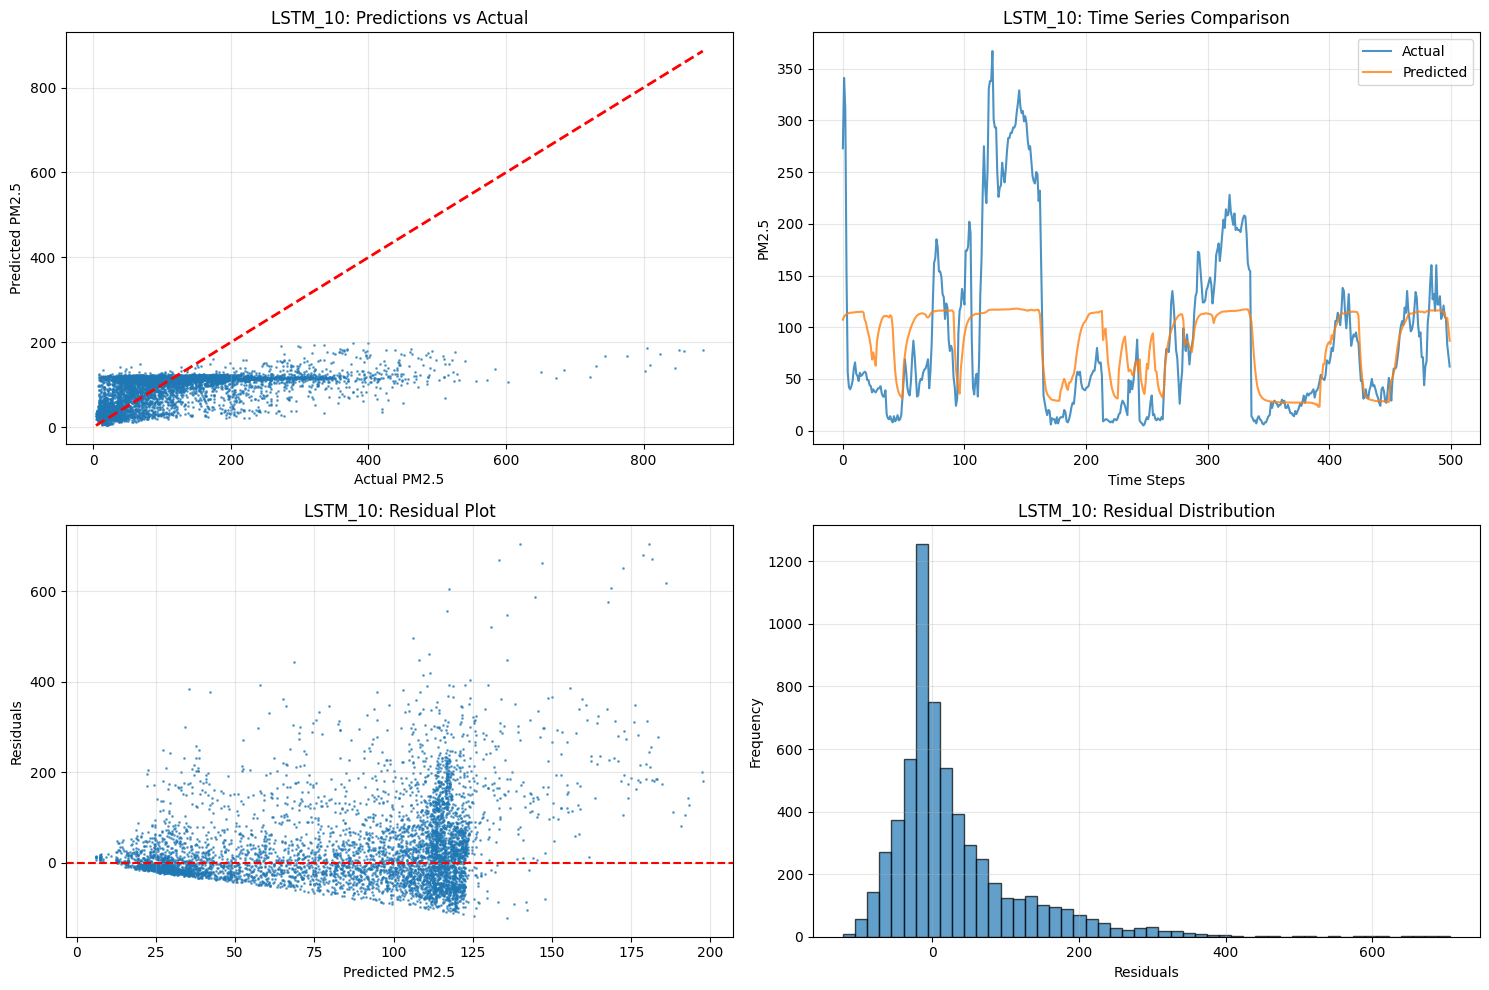


===== Experiment 11: LSTM, 3 layers, 128 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 76s 48ms/step - loss: 0.9231 - mae: 0.7242 - val_loss: 1.4200 - val_mae: 0.8272 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 76s 48ms/step - loss: 0.9231 - mae: 0.7242 - val_loss: 1.4200 - val_mae: 0.8272 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 12042s 8s/step - loss: 0.9063 - mae: 0.7103 - val_loss: 1.4577 - val_mae: 0.8273 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 12042s 8s/step - loss: 0.9063 - mae: 0.7103 - val_loss: 1.4577 - val_mae: 0.8273 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 69s 45ms/step

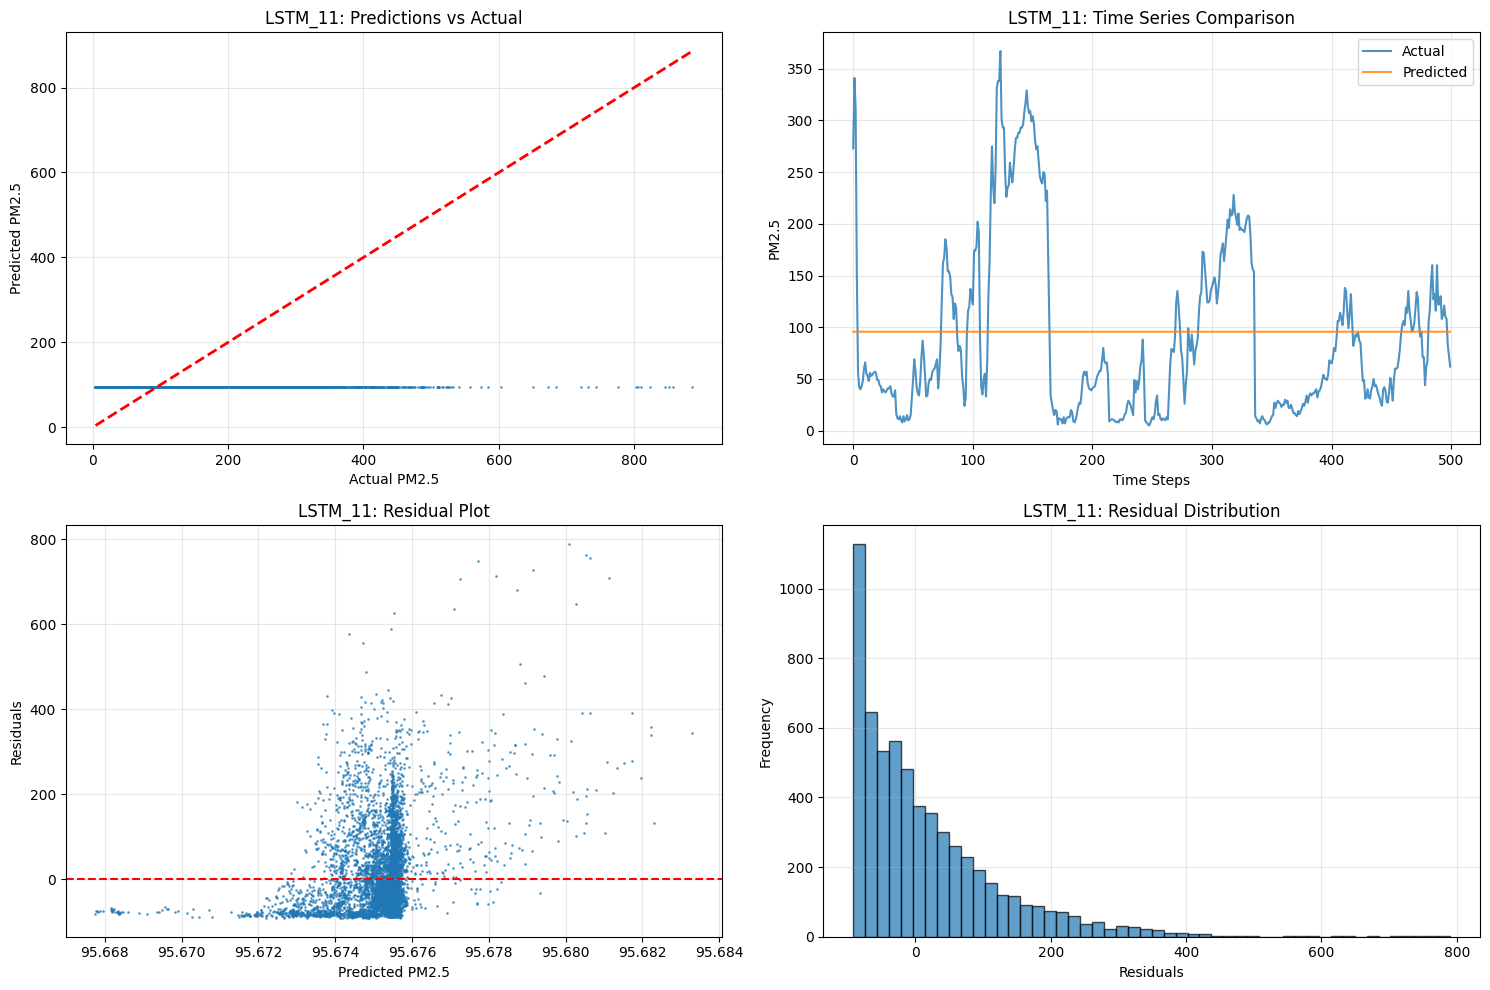


===== Experiment 12: GRU, 3 layers, 128 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 90s 56ms/step - loss: 1.0373 - mae: 0.7626 - val_loss: 1.3889 - val_mae: 0.8312 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 90s 56ms/step - loss: 1.0373 - mae: 0.7626 - val_loss: 1.3889 - val_mae: 0.8312 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 103s 67ms/step - loss: 0.9343 - mae: 0.7182 - val_loss: 1.3898 - val_mae: 0.8157 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 103s 67ms/step - loss: 0.9343 - mae: 0.7182 - val_loss: 1.3898 - val_mae: 0.8157 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 95s 62ms/step 

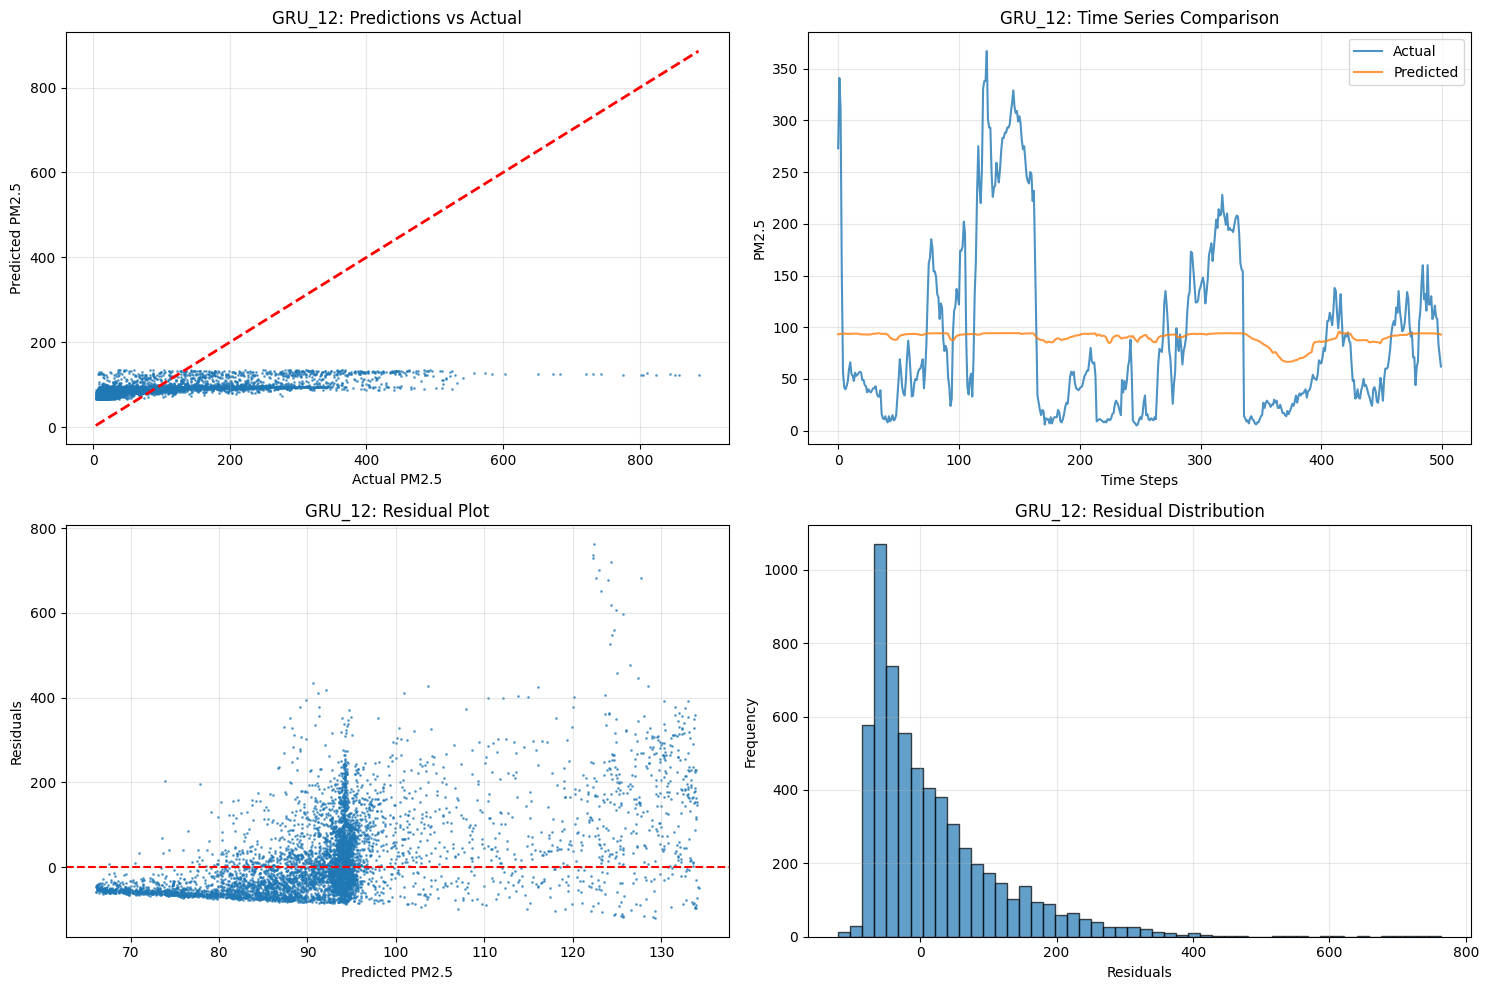


===== Experiment 13: LSTM, 2 layers, 64 units, rmsprop, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 138s 86ms/step - loss: 0.6580 - mae: 0.5734 - val_loss: 1.2419 - val_mae: 0.6874 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 138s 86ms/step - loss: 0.6580 - mae: 0.5734 - val_loss: 1.2419 - val_mae: 0.6874 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 99s 65ms/step - loss: 0.4629 - mae: 0.4719 - val_loss: 1.0490 - val_mae: 0.6362 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 99s 65ms/step - loss: 0.4629 - mae: 0.4719 - val_loss: 1.0490 - val_mae: 0.6362 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 125s 82ms/s

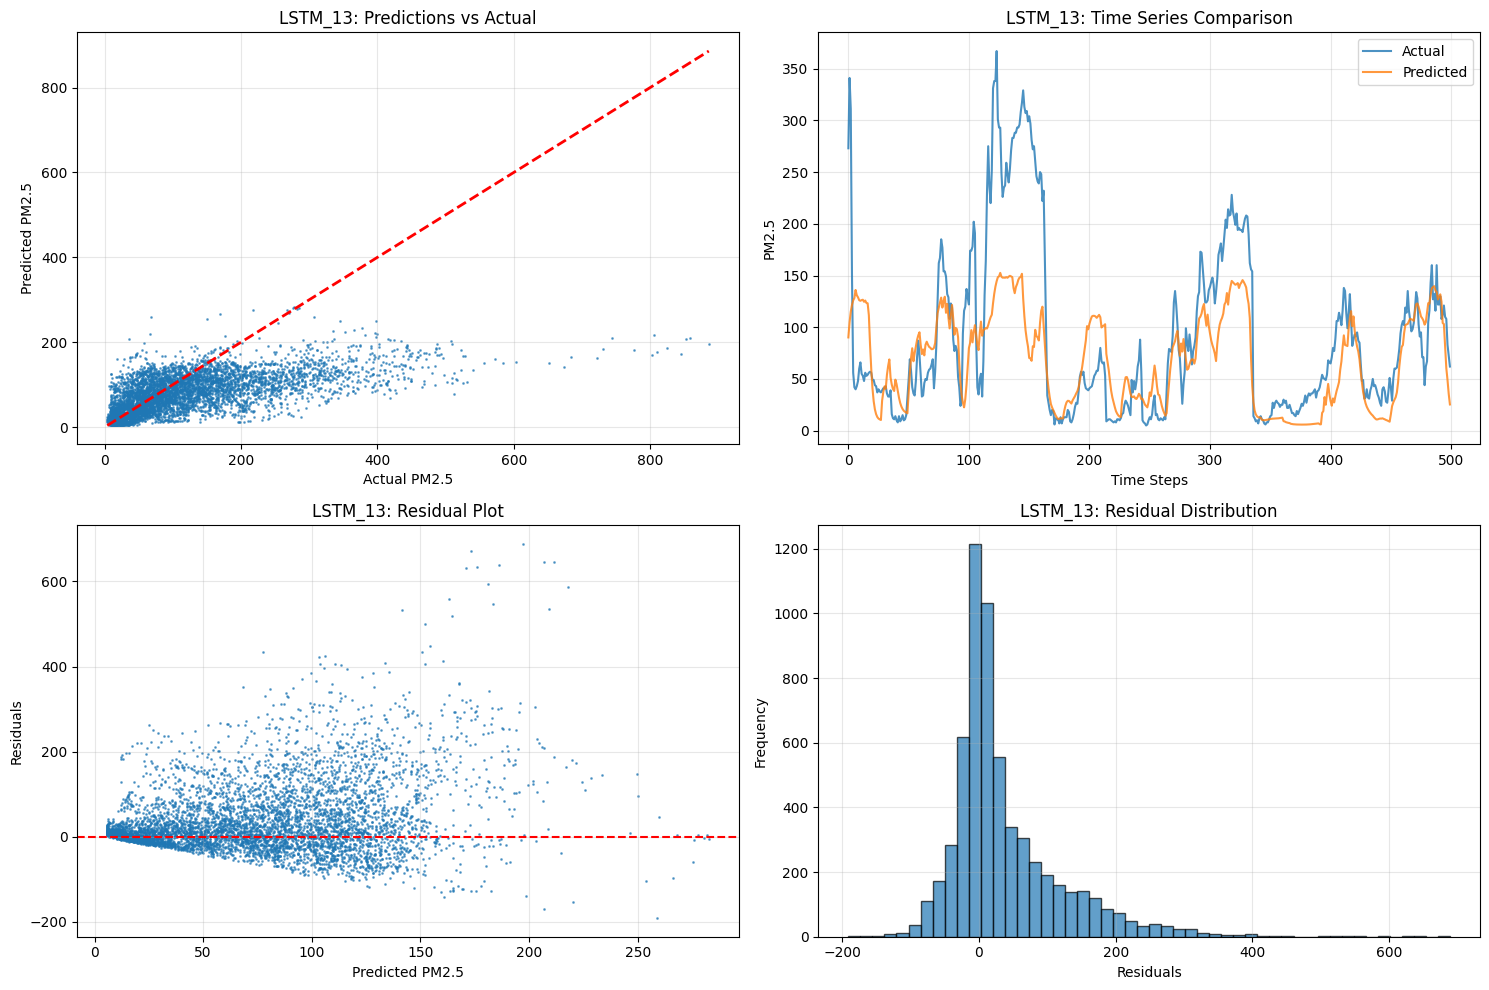


===== Experiment 14: GRU, 2 layers, 64 units, rmsprop, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 154s 96ms/step - loss: 0.6650 - mae: 0.5797 - val_loss: 1.2497 - val_mae: 0.7030 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 154s 96ms/step - loss: 0.6650 - mae: 0.5797 - val_loss: 1.2497 - val_mae: 0.7030 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 119s 78ms/step - loss: 0.4572 - mae: 0.4732 - val_loss: 1.1788 - val_mae: 0.6722 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 119s 78ms/step - loss: 0.4572 - mae: 0.4732 - val_loss: 1.1788 - val_mae: 0.6722 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 134s 87ms/

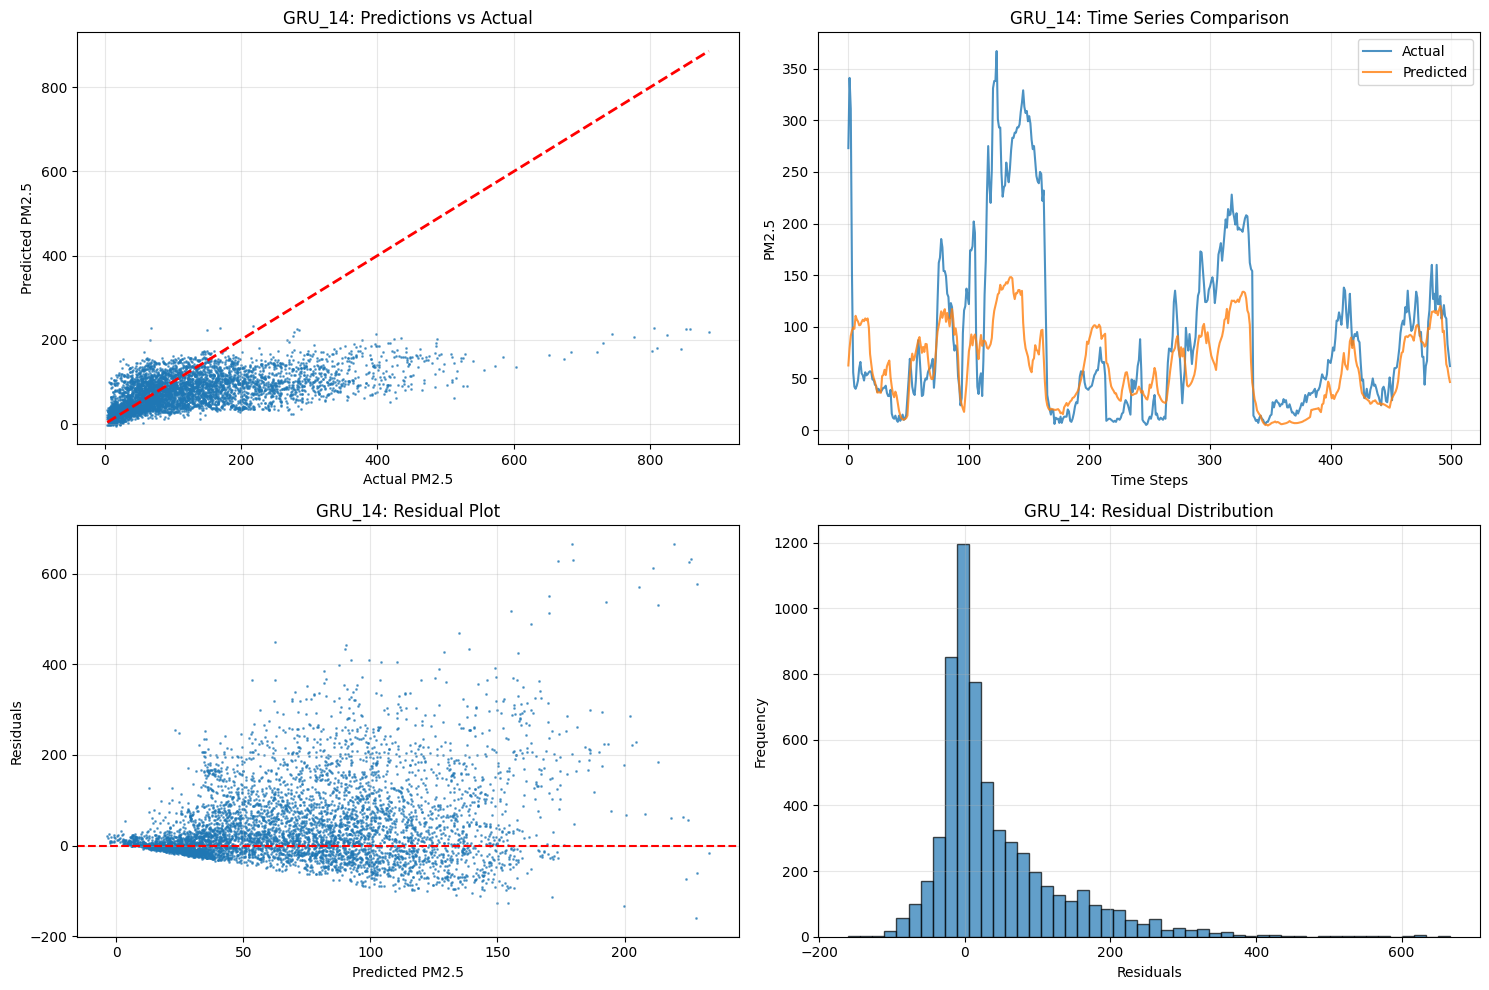


===== Experiment 15: LSTM, 1 layers, 32 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 132s 83ms/step - loss: 0.9467 - mae: 0.7292 - val_loss: 1.3680 - val_mae: 0.8023 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 132s 83ms/step - loss: 0.9467 - mae: 0.7292 - val_loss: 1.3680 - val_mae: 0.8023 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 132s 86ms/step - loss: 0.8655 - mae: 0.6865 - val_loss: 1.2749 - val_mae: 0.7719 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 132s 86ms/step - loss: 0.8655 - mae: 0.6865 - val_loss: 1.2749 - val_mae: 0.7719 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 124s 81ms/st

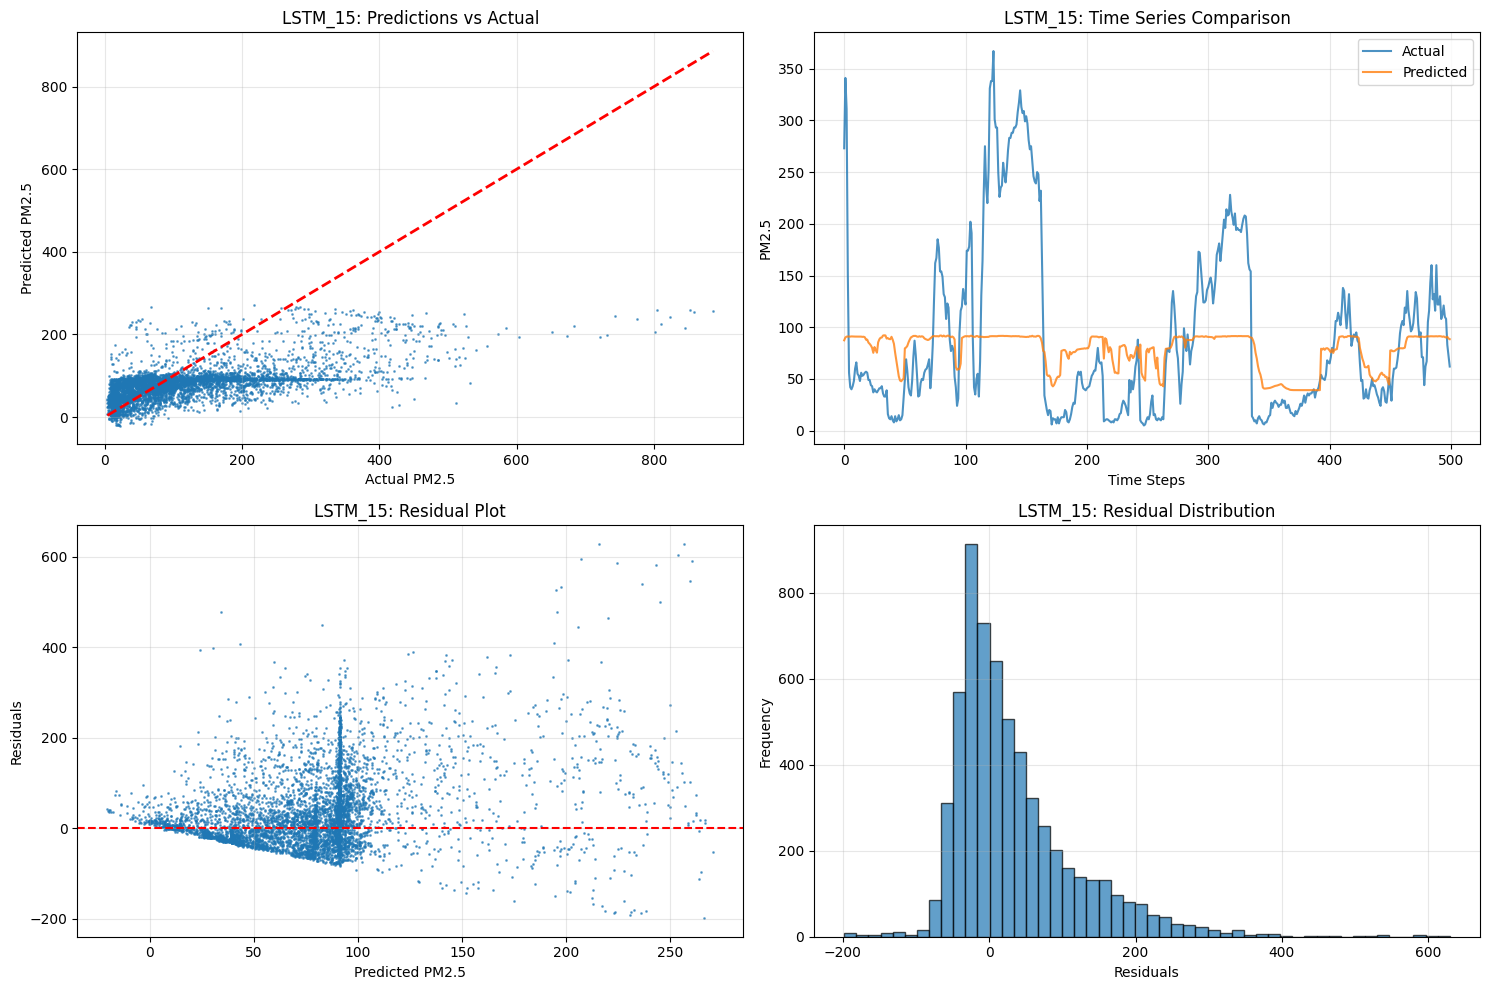


===== Experiment 16: GRU, 1 layers, 32 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 136s 85ms/step - loss: 1.1744 - mae: 0.8229 - val_loss: 1.3828 - val_mae: 0.8122 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 136s 85ms/step - loss: 1.1744 - mae: 0.8229 - val_loss: 1.3828 - val_mae: 0.8122 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 61s 40ms/step - loss: 0.9784 - mae: 0.7502 - val_loss: 1.2711 - val_mae: 0.7935 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 61s 40ms/step - loss: 0.9784 - mae: 0.7502 - val_loss: 1.2711 - val_mae: 0.7935 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 48s 31ms/step -

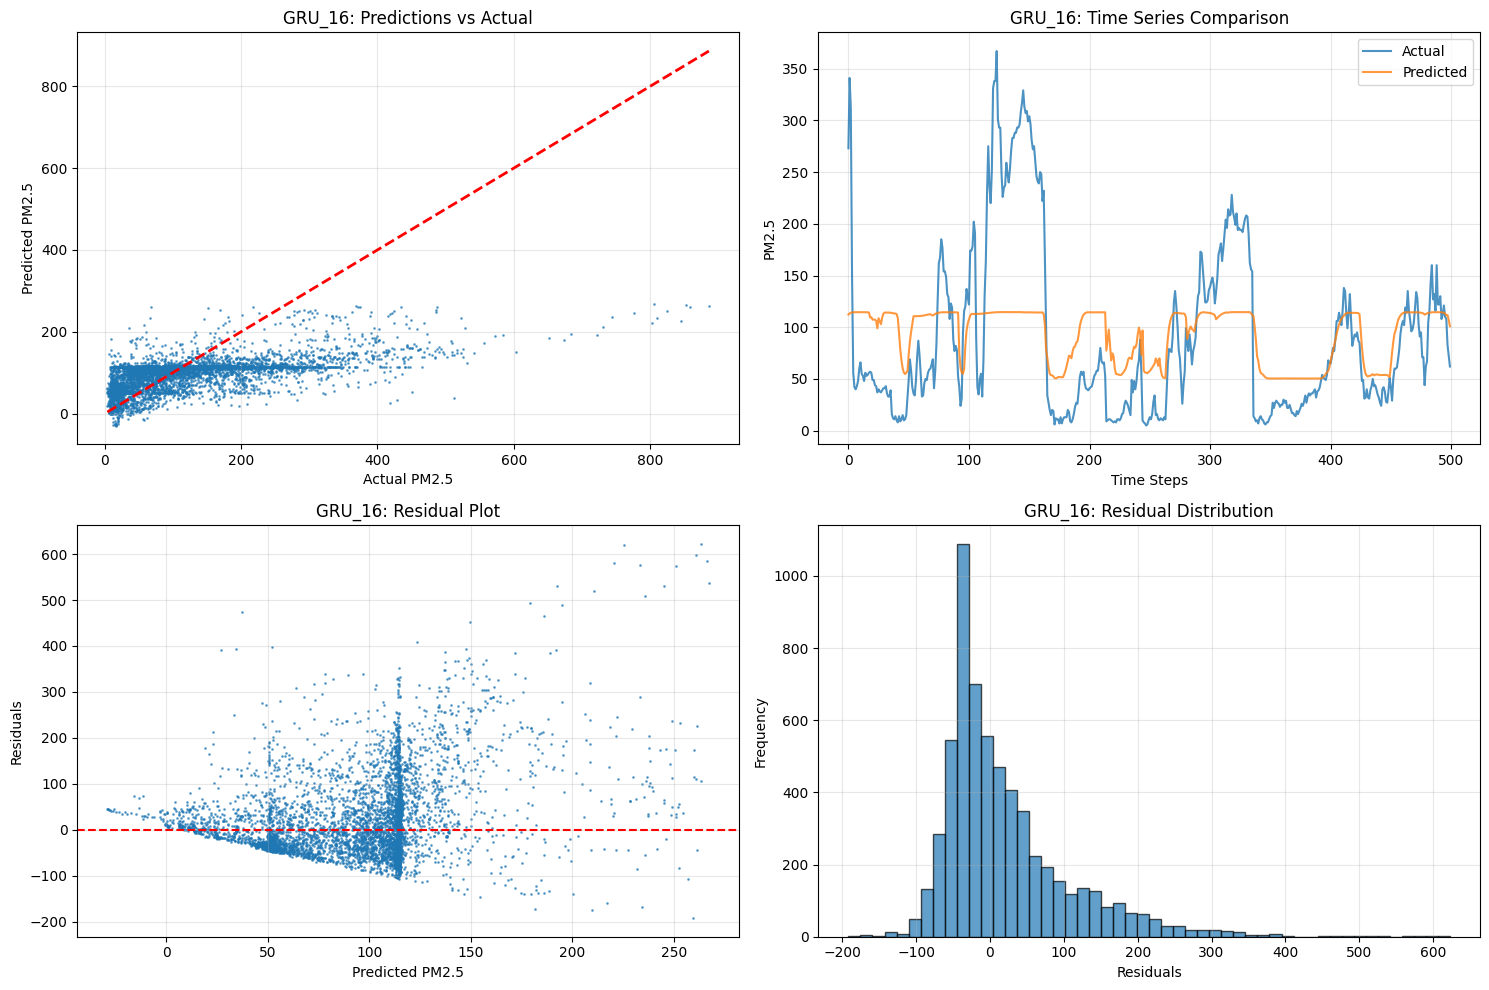


===== Experiment 17: LSTM, 2 layers, 200 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 102s 65ms/step - loss: 0.9382 - mae: 0.7332 - val_loss: 1.4090 - val_mae: 0.8266 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 102s 65ms/step - loss: 0.9382 - mae: 0.7332 - val_loss: 1.4090 - val_mae: 0.8266 - lr: 0.0010
Epoch 2/5
1532/1532 [==============================] - 103s 67ms/step - loss: 0.9068 - mae: 0.7101 - val_loss: 1.4486 - val_mae: 0.8229 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 103s 67ms/step - loss: 0.9068 - mae: 0.7101 - val_loss: 1.4486 - val_mae: 0.8229 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 111s 72ms/s

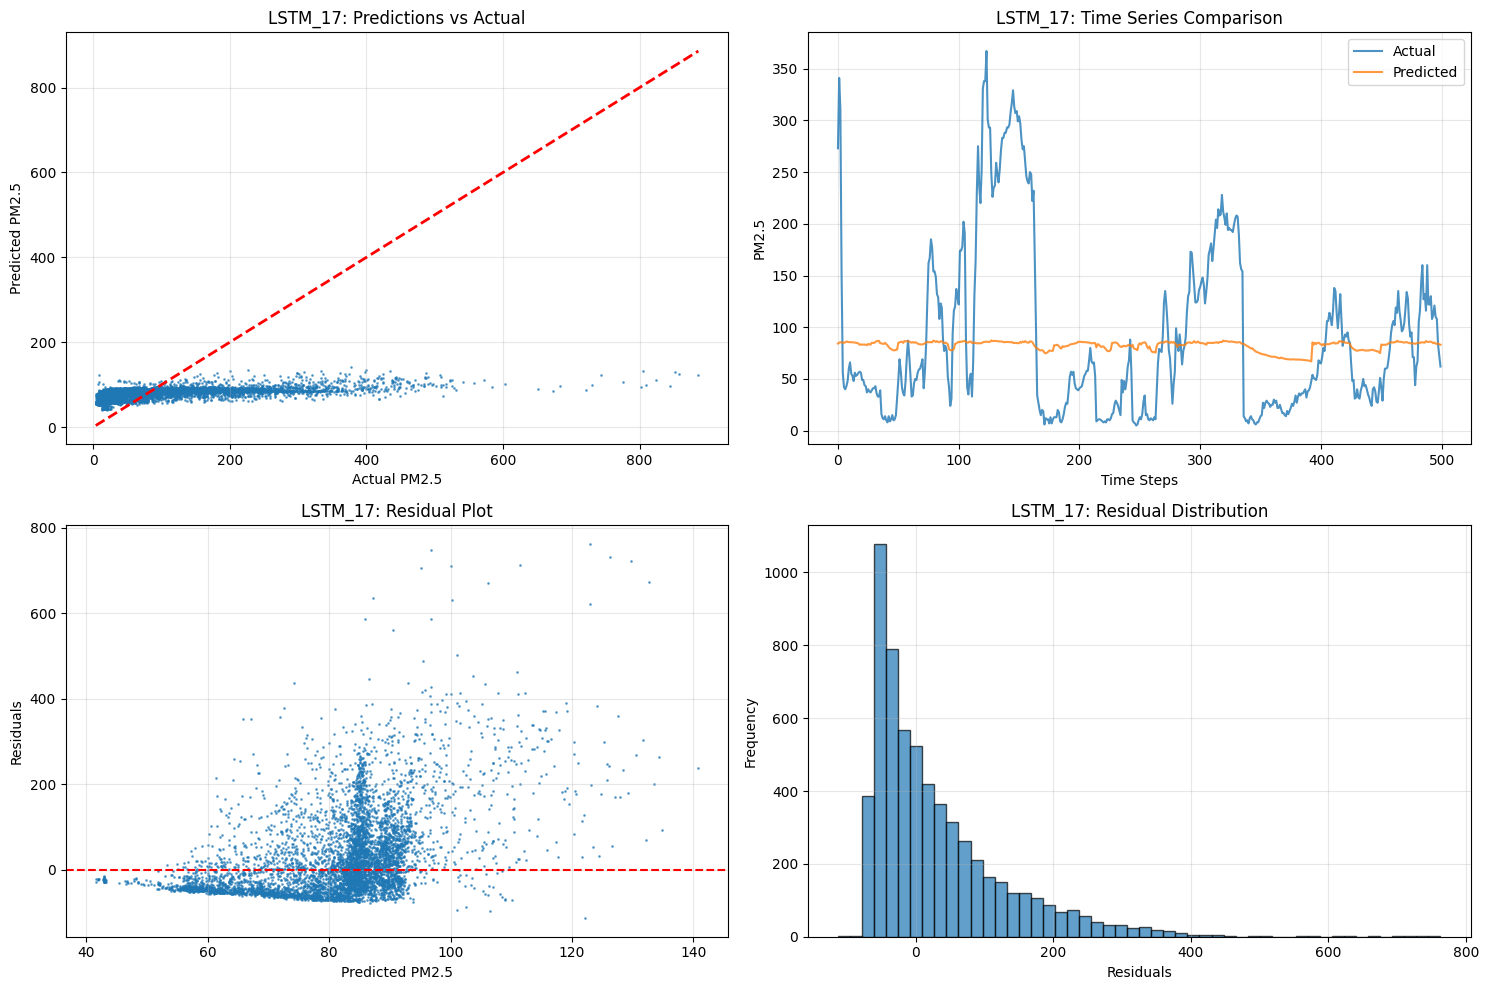


===== Experiment 18: GRU, 2 layers, 200 units, adam, lr=0.001, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 228s 142ms/step - loss: 1.1825 - mae: 0.8182 - val_loss: 1.4050 - val_mae: 0.8259 - lr: 0.0010
Epoch 2/5
Epoch 2/5
1532/1532 [==============================] - 165s 108ms/step - loss: 0.9683 - mae: 0.7332 - val_loss: 1.4277 - val_mae: 0.8187 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 165s 108ms/step - loss: 0.9683 - mae: 0.7332 - val_loss: 1.4277 - val_mae: 0.8187 - lr: 0.0010
Epoch 3/5
1532/1532 [==============================] - 170s 111ms/step - loss: 0.9189 - mae: 0.7054 - val_loss: 1.3684 - val_mae: 0.7997 - lr: 0.0010
Epoch 4/5
1532/1532 [==============================] 

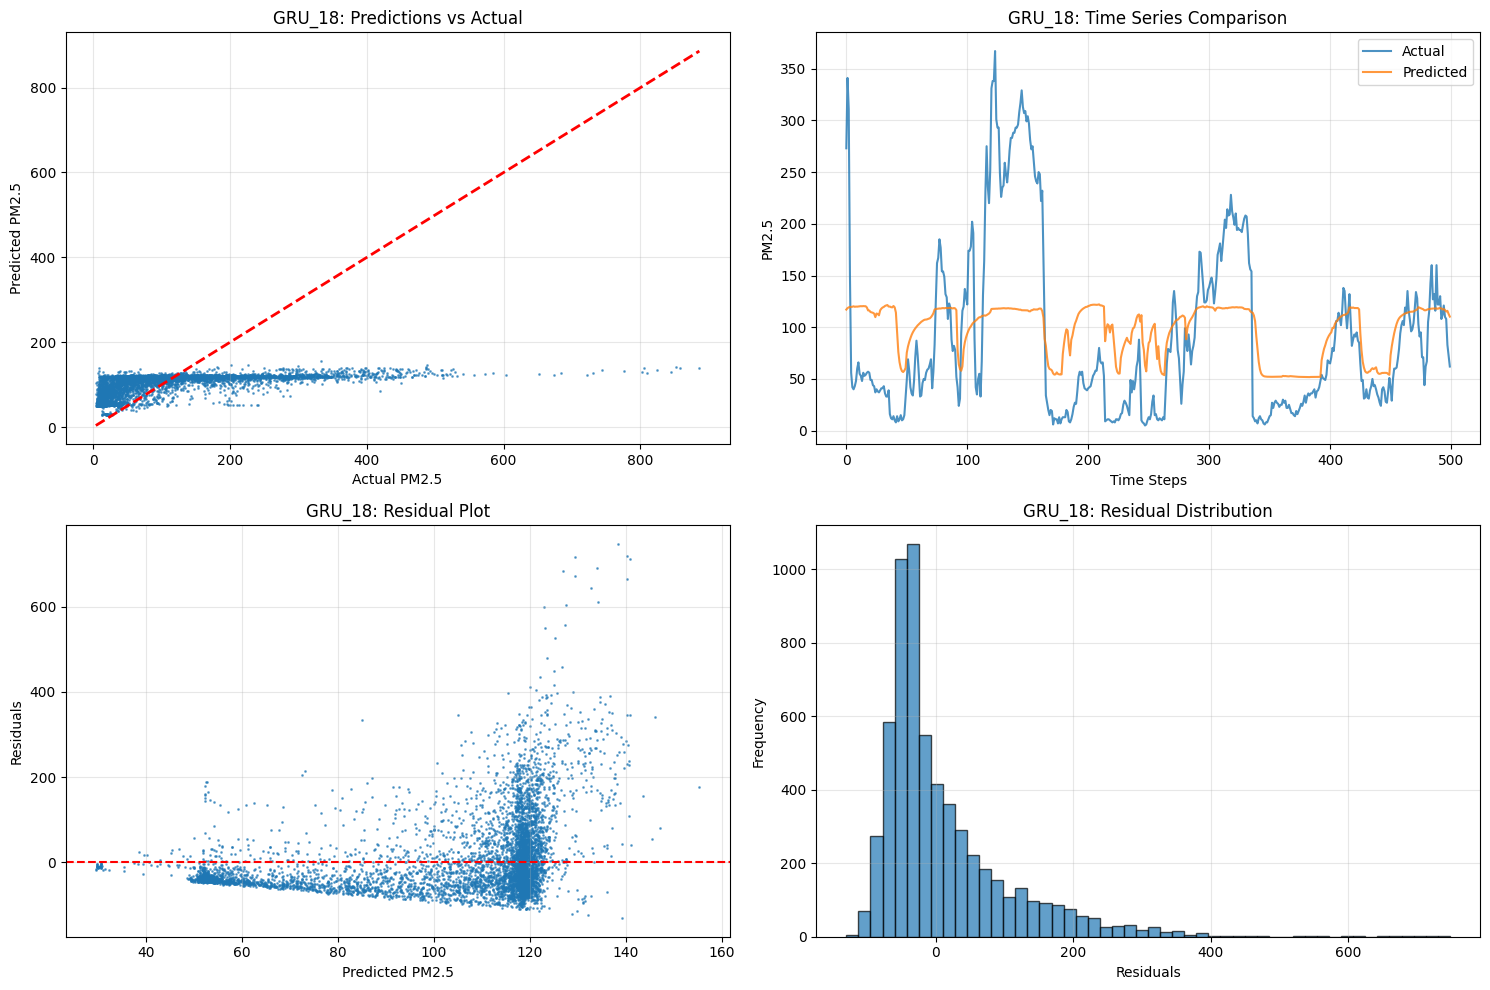


===== Experiment 19: LSTM, 2 layers, 100 units, adam, lr=0.002, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 144s 90ms/step - loss: 0.9331 - mae: 0.7312 - val_loss: 1.4105 - val_mae: 0.8257 - lr: 0.0020
Epoch 2/5
Epoch 2/5
1532/1532 [==============================] - 136s 89ms/step - loss: 0.8987 - mae: 0.7075 - val_loss: 1.4627 - val_mae: 0.8257 - lr: 0.0020
Epoch 3/5
1532/1532 [==============================] - 136s 89ms/step - loss: 0.8987 - mae: 0.7075 - val_loss: 1.4627 - val_mae: 0.8257 - lr: 0.0020
Epoch 3/5
1532/1532 [==============================] - 144s 94ms/step - loss: 0.8695 - mae: 0.6852 - val_loss: 1.4655 - val_mae: 0.8206 - lr: 0.0020
Epoch 4/5
Epoch 4/5
1532/1532 [=========================

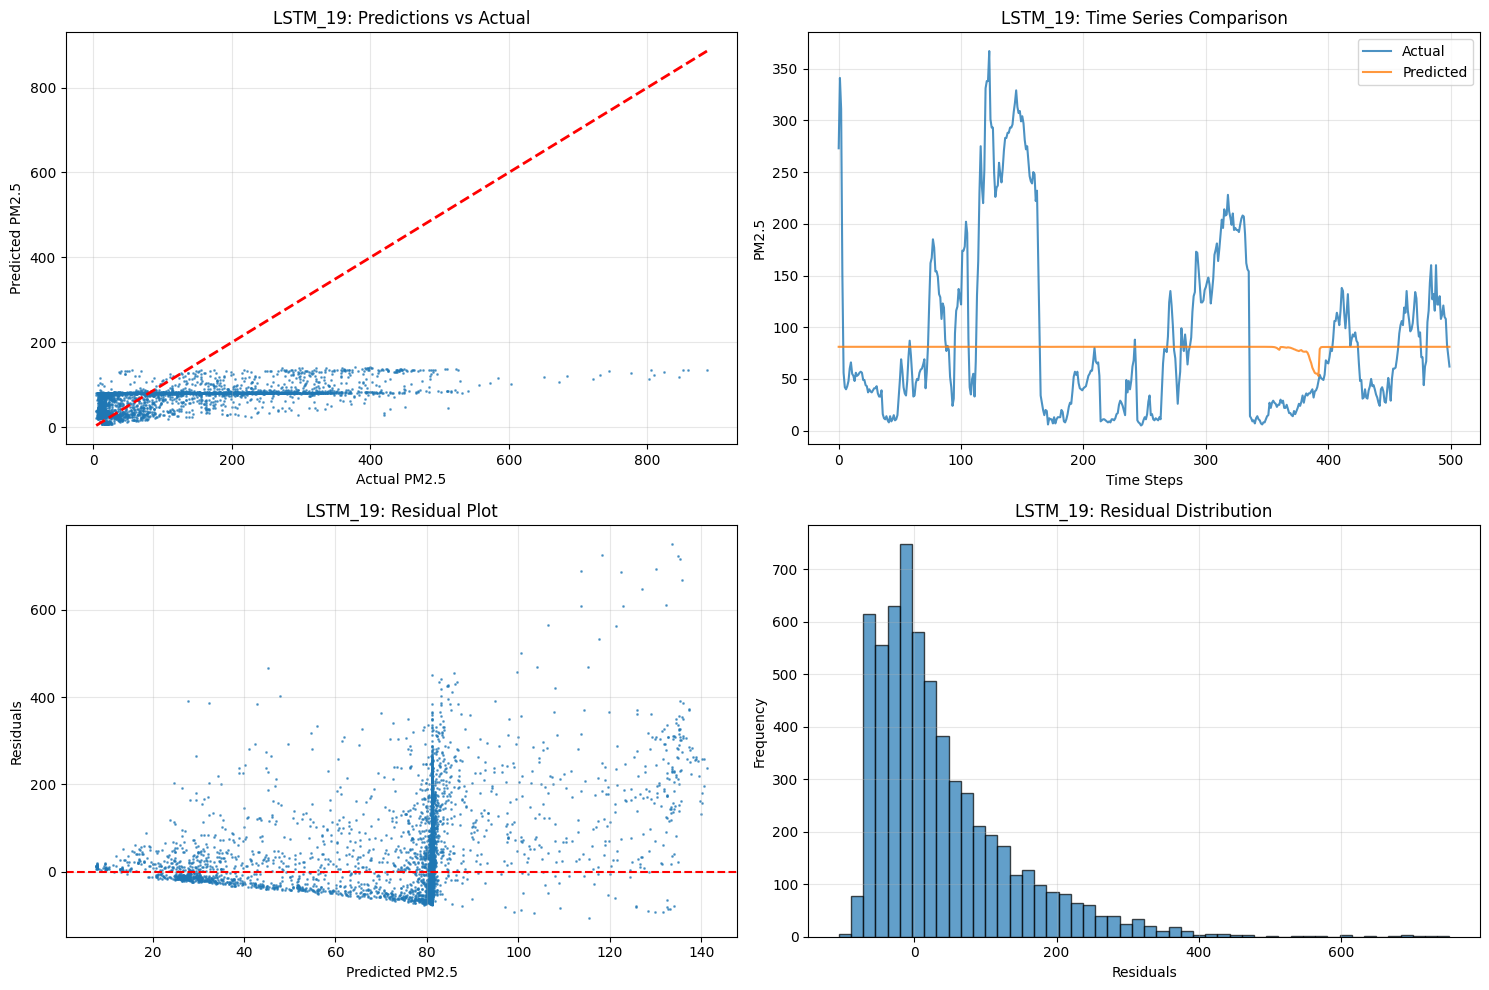


===== Experiment 20: GRU, 2 layers, 100 units, adam, lr=0.002, batch=16 =====
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
Train steps: 1532, Validation steps: 381, Test sequences: (13124, 24, 24)
Each sequence uses 24 time steps with 24 features
Epoch 1/5
1532/1532 [==============================] - 384s 247ms/step - loss: 1.0904 - mae: 0.7786 - val_loss: 1.4446 - val_mae: 0.8255 - lr: 0.0020
Epoch 2/5
Epoch 2/5
1532/1532 [==============================] - 162s 105ms/step - loss: 0.9895 - mae: 0.7377 - val_loss: 1.3869 - val_mae: 0.8298 - lr: 0.0020
Epoch 3/5
1532/1532 [==============================] - 162s 105ms/step - loss: 0.9895 - mae: 0.7377 - val_loss: 1.3869 - val_mae: 0.8298 - lr: 0.0020
Epoch 3/5
1532/1532 [==============================] - 122s 80ms/step - loss: 0.9499 - mae: 0.7170 - val_loss: 1.3470 - val_mae: 0.8322 - lr: 0.0020
Epoch 4/5
Epoch 4/5
1532/1532 [=======================

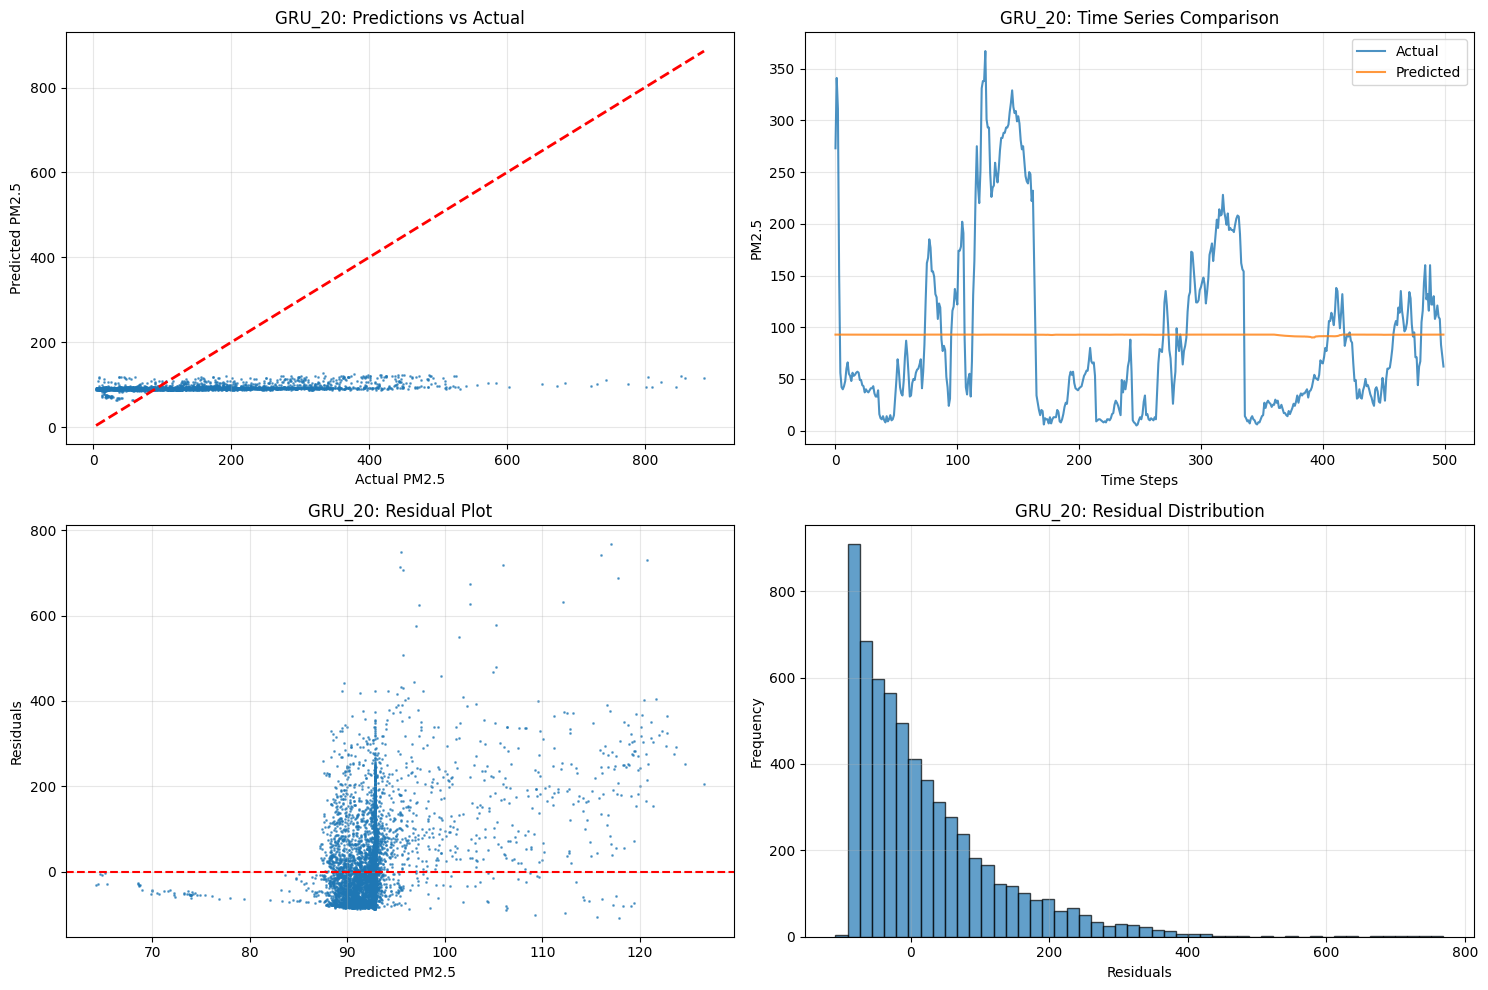

Experiment Model  Layers  Units Optimizer      LR  Batch Size        RMSE
0            1  lstm       1     50      adam  0.0010          16   86.438148
1            2  lstm       2    100      adam  0.0010          16   93.057198
2            3  lstm       2    100      adam  0.0005          16   94.739563
3            4  lstm       2    100       sgd  0.0100          16  109.826363
4            5   gru       1     50      adam  0.0010          16  100.026642
5            6   gru       2    100      adam  0.0010          16   98.018539
6            7   gru       2    100      adam  0.0005          16   88.058472
7            8   gru       2    100       sgd  0.0100          16  108.823860
8            9  lstm       2    100      adam  0.0010          32   90.189468
9           10  lstm       2    100      adam  0.0010           8   93.866180
10          11  lstm       3    128      adam  0.0010          16  107.207443
11          12   gru       3    128      adam  0.0010          16  100.173256
12          13  lstm       2     64   rmsprop  0.0010          16   91.989372
13          14   gru       2     64   rmsprop  0.0010          16   96.201233
14          15  lstm       1     32      adam  0.0010          16   91.854683
15          16   gru       1     32      adam  0.0010          16   89.612633
16          17  lstm       2    200      adam  0.0010          16  104.425659
17          18   gru       2    200      adam  0.0010          16   95.158600
18          19  lstm       2    100      adam  0.0020          16  104.725327
19          20   gru       2    100      adam  0.0020          16  105.616280

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

# Define experiment configurations 
experiments = [
    # (exp_id, model_type, n_layers, units, optimizer, lr, batch_size)
    (1, 'lstm', 1, 50, 'adam', 0.001, 16),
    (2, 'lstm', 2, 100, 'adam', 0.001, 16),
    (3, 'lstm', 2, 100, 'adam', 0.0005, 16),
    (4, 'lstm', 2, 100, 'sgd', 0.01, 16),
    (5, 'gru', 1, 50, 'adam', 0.001, 16),
    (6, 'gru', 2, 100, 'adam', 0.001, 16),
    (7, 'gru', 2, 100, 'adam', 0.0005, 16),
    (8, 'gru', 2, 100, 'sgd', 0.01, 16),
    (9, 'lstm', 2, 100, 'adam', 0.001, 32),
    (10, 'lstm', 2, 100, 'adam', 0.001, 8),
    (11, 'lstm', 3, 128, 'adam', 0.001, 16),
    (12, 'gru', 3, 128, 'adam', 0.001, 16),
    (13, 'lstm', 2, 64, 'rmsprop', 0.001, 16),
    (14, 'gru', 2, 64, 'rmsprop', 0.001, 16),
    (15, 'lstm', 1, 32, 'adam', 0.001, 16),
    (16, 'gru', 1, 32, 'adam', 0.001, 16),
    (17, 'lstm', 2, 200, 'adam', 0.001, 16),
    (18, 'gru', 2, 200, 'adam', 0.001, 16),
    (19, 'lstm', 2, 100, 'adam', 0.002, 16),
    (20, 'gru', 2, 100, 'adam', 0.002, 16),
    # Add more if desired
    ]

results = []
for exp in experiments:
    exp_id, model_type, n_layers, units, optimizer, lr, batch_size = exp
    print(f'\n===== Experiment {exp_id}: {model_type.upper()}, {n_layers} layers, {units} units, {optimizer}, lr={lr}, batch={batch_size} =====')
    # Build model
    def build_model():
        model = Sequential()
        for i in range(n_layers):
            return_seq = (i < n_layers - 1)
            if model_type == 'lstm':
                if i == 0:
                    model.add(LSTM(units, return_sequences=return_seq, input_shape=(lookback, len(common_feature_cols))))
                else:
                    model.add(LSTM(units, return_sequences=return_seq))
            else:
                if i == 0:
                    model.add(GRU(units, return_sequences=return_seq, input_shape=(lookback, len(common_feature_cols))))
                else:
                    model.add(GRU(units, return_sequences=return_seq))
            model.add(Dropout(0.2))
        model.add(Dense(1))
        return model

    model = build_model()
    # Select optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=lr)
    else:
        opt = RMSprop(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])

    Lookback = 24  
    

    # Create new generators for each experiment to avoid state issues
    train_gen, val_gen, X_test, steps_per_epoch, val_steps = create_lstm_sequences_generator(
        train_featured_scaled, test_featured_scaled, common_feature_cols, lookback=lookback, batch_size=batch_size)

    # Train for 10 epochs only
    history = train_model_generator(
        model, train_gen, val_gen, steps_per_epoch, val_steps,
        model_name=f'{model_type.upper()}_{exp_id}', epochs=5)

    # Evaluate
    metrics, _, _ = evaluate_model_generator(
        model, val_gen, val_steps, target_scaler, model_name=f'{model_type.upper()}_{exp_id}')

    results.append({
        'Experiment': exp_id,
        'Model': model_type,
        'Layers': n_layers,
        'Units': units,
        'Optimizer': optimizer,
        'LR': lr,
        'Batch Size': batch_size,
        'RMSE': metrics['RMSE']
    })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv('../output_submissions/experiment_results.csv', index=False)
display(results_df)

In [114]:
output_dir = "output_submissions"
os.makedirs(output_dir, exist_ok=True)

# Looping  through experiments ===
for exp_id, model_type, n_layers, units, optimizer, lr, batch_size in experiments:
    print(f" Running predictions for Experiment {exp_id} ...")

    
    # For now, I’ll assume you already have the trained model object `model`
    preds = model.predict(X_test, verbose=0)

    # Clean + postprocess
    preds = np.nan_to_num(preds)
    preds = np.round(preds).astype(int)

    # Build submission
    submission = pd.DataFrame({
        "row ID": pd.to_datetime(test_featured_scaled.index[lookback:]).strftime("%Y-%m-%d %H:%M:%S"),
        "pm2.5": preds.flatten()
    }).sort_values(by="row ID")

    # === File naming format ===
    filename = f"subm_fixed_{exp_id}.csv"
    filepath = os.path.join(output_dir, filename)

    # Save submission
    submission.to_csv(filepath, index=False)
    print(f" Saved submission: {filepath}")

 Running predictions for Experiment 1 ...
 Saved submission: output_submissions\subm_fixed_1.csv
 Running predictions for Experiment 2 ...
 Saved submission: output_submissions\subm_fixed_1.csv
 Running predictions for Experiment 2 ...
 Saved submission: output_submissions\subm_fixed_2.csv
 Running predictions for Experiment 3 ...
 Saved submission: output_submissions\subm_fixed_2.csv
 Running predictions for Experiment 3 ...
 Saved submission: output_submissions\subm_fixed_3.csv
 Running predictions for Experiment 4 ...
 Saved submission: output_submissions\subm_fixed_3.csv
 Running predictions for Experiment 4 ...
 Saved submission: output_submissions\subm_fixed_4.csv
 Running predictions for Experiment 5 ...
 Saved submission: output_submissions\subm_fixed_4.csv
 Running predictions for Experiment 5 ...
 Saved submission: output_submissions\subm_fixed_5.csv
 Running predictions for Experiment 6 ...
 Saved submission: output_submissions\subm_fixed_5.csv
 Running predictions for Exper

#### The single-layer LSTM with 50 hidden units and Adam optimizer (lr=0.001, batch=16) is the best-performing configuration because it produced the lowest RMSE (86.44), showing a good balance between simplicity and accuracy.